## Условие задачи

Чтобы оптимизировать производственные расходы, металлургический комбинат ООО «Так закаляем сталь» решил уменьшить потребление электроэнергии на этапе обработки стали. Вам предстоит построить модель, которая предскажет температуру стали.

### Описание этапа обработки

Сталь обрабатывают в металлическом ковше вместимостью около 100 тонн. Чтобы ковш выдерживал высокие температуры, изнутри его облицовывают огнеупорным кирпичом. Расплавленную сталь заливают в ковш и подогревают до нужной температуры графитовыми электродами. Они установлены в крышке ковша. 

Из сплава выводится сера (десульфурация), добавлением примесей корректируется химический состав и отбираются пробы. Сталь легируют — изменяют её состав — подавая куски сплава из бункера для сыпучих материалов или проволоку через специальный трайб-аппарат (англ. tribe, «масса»).

Перед тем как первый раз ввести легирующие добавки, измеряют температуру стали и производят её химический анализ. Потом температуру на несколько минут повышают, добавляют легирующие материалы и продувают сплав инертным газом. Затем его перемешивают и снова проводят измерения. Такой цикл повторяется до достижения целевого химического состава и оптимальной температуры плавки.

Тогда расплавленная сталь отправляется на доводку металла или поступает в машину непрерывной разливки. Оттуда готовый продукт выходит в виде заготовок-слябов (англ. *slab*, «плита»).

### Описание данных

Данные состоят из файлов, полученных из разных источников:

- `data_arc.csv` — данные об электродах;
- `data_bulk.csv` — данные о подаче сыпучих материалов (объём);
- `data_bulk_time.csv` *—* данные о подаче сыпучих материалов (время);
- `data_gas.csv` — данные о продувке сплава газом;
- `data_temp.csv` — результаты измерения температуры;
- `data_wire.csv` — данные о проволочных материалах (объём);
- `data_wire_time.csv` — данные о проволочных материалах (время).

Во всех файлах столбец `key` содержит номер партии. В файлах может быть несколько строк с одинаковым значением `key`: они соответствуют разным итерациям обработки.

### Содержание

##### Часть 1. Исследовательский анализ данных:
* [1. Данные об электродах (data_arc)](#1)
* [2. Результаты измерения температуры (data_temp)](#2)
* [3. Данные о продувке сплава газом (data_gas)](#3)
* [4. Данные о подаче сыпучих материалов (data_arc)](#4)
* [5. Данные о подаче проволочных материалов (data_wire)](#5)
* [6. Прочие](#6)


##### Часть 2. Предобработка и "склеивание" датафрейма:
* [1. Собираем данные в один датафрейм](#7)
* [2. Добавляем новые признаки](#8)
* [3. Разделение на тестовую и обучающую выборки. Очистка обучающей выборки от выбросов.](#9)


##### Часть 3. Обучение моделей:
* [1. Линейная регрессия до отбора признаков.](#10)
* [2. Lightgbm+Bagging до отбора признаков.](#11)
* [3. Случайный лес.](#12)
* [4. Отбор признаков. Lightgbm+Bagging после отбора признаков.](#13)
* [5. Линейная регрессия после отбора признаков.](#14)
* [6. Lightgbm+Bagging до отбора признаков.](#15)
* [7. Константная модель.](#16)

##### Часть 4. [Анализ моделей](#17)

#### [Вывод](#17)

In [1]:
import pandas as pd
import numpy as np

from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

import time

import lightgbm as lgb
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import RandomForestRegressor

plt.rcParams.update(plt.rcParamsDefault)

In [2]:
#Загрузим данные
data_arc = pd.read_csv('datasets/data_arc.csv')
data_bulk = pd.read_csv('datasets/data_bulk.csv')
data_bulk_time = pd.read_csv('datasets/data_bulk_time.csv')
data_gas = pd.read_csv('datasets/data_gas.csv')
data_temp = pd.read_csv('datasets/data_temp.csv')
data_wire = pd.read_csv('datasets/data_wire.csv')
data_wire_time = pd.read_csv('datasets/data_wire_time.csv')

## 1. Исследовательский анализ данных.

In [4]:
# Поглянем данные:
data_list = [data_arc, data_bulk, data_bulk_time, data_gas, data_temp, data_wire, data_wire_time]


<a id='1'></a>
### 1.1 Данные об электродах (data_arc)

In [5]:
# Начнём с данных об электрической дуге:
data_arc.head(3)

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805


In [6]:
data_arc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   14876 non-null  int64  
 1   Начало нагрева дугой  14876 non-null  object 
 2   Конец нагрева дугой   14876 non-null  object 
 3   Активная мощность     14876 non-null  float64
 4   Реактивная мощность   14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB


In [7]:
print('Партий: {}'.format(data_arc['key'].nunique()))
print('В среднем итераций на одну партию: {}'.format(data_arc.shape[0]/data_arc['key'].nunique()))
print('Датафрейм содержит данные с {} по {}'.format(data_arc['Начало нагрева дугой'].min(), data_arc['Начало нагрева дугой'].max()))

print('Информация о пропусках по колонкам: ')
display(data_arc.isna().sum())

Партий: 3214
В среднем итераций на одну партию: 4.628500311138768
Датафрейм содержит данные с 2019-05-03 11:02:14 по 2019-09-01 04:34:47
Информация о пропусках по колонкам: 


key                     0
Начало нагрева дугой    0
Конец нагрева дугой     0
Активная мощность       0
Реактивная мощность     0
dtype: int64

In [8]:
# Преобразуем данные о дате и времени в формат datetime и извлечем из них фичу "Длительность нагрева":
data_arc['Начало нагрева дугой'] = pd.to_datetime(data_arc['Начало нагрева дугой'])
data_arc['Конец нагрева дугой'] = pd.to_datetime(data_arc['Конец нагрева дугой'])
data_arc['Длительность нагрева'] = (data_arc['Конец нагрева дугой'] - data_arc['Начало нагрева дугой']).dt.seconds

data_arc.drop(columns=['Начало нагрева дугой', 'Конец нагрева дугой'], inplace=True)

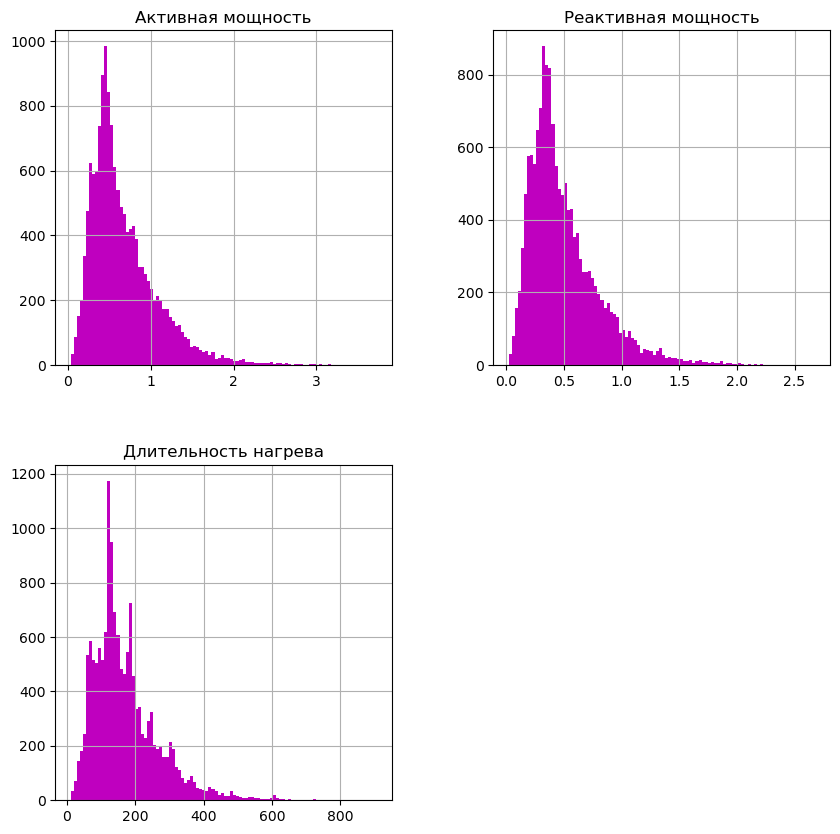

In [9]:
# Для корректности отображения данных по реактивной мощности необходимо отсеять выброс:
data_arc = data_arc[data_arc['Реактивная мощность'] > 0]
# Построим распределния получившихся признаков:
data_arc.drop(columns=['key']).hist(figsize=(10,10), bins=100, color='m')
plt.show()

In [10]:
def build_boxplots(data, color):
    """
    Функция строит ящики с усами.
    data - обрабатываемый датафрейм 
    
    """ 
    for col in data.columns:
        plt.figure(figsize=(15,1))
        ax = sns.boxplot(x=data[col], data=data[col],  color=color)
        plt.show()

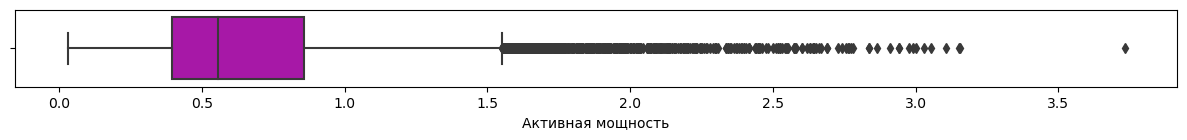

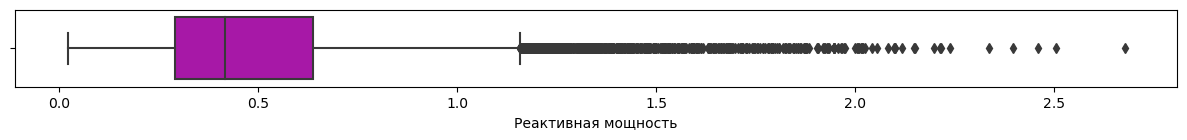

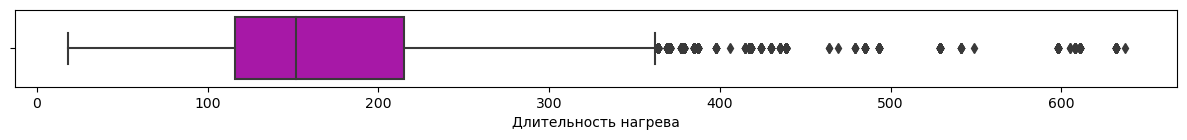

In [11]:
#Построим ящики с усами, чтобы ближе взглянуть на выбросы:


build_boxplots(data_arc.drop(columns=['key']), 'm')

1) Имеем датафрейм с 14876 записями, отражающими общее количество итераций c марта по сентябрь 2019 года. Представлено 3214 уникальных партий, в среднем требуется 4-5 итераций на партию.

2) Преобразуем дату и время в тип datetime, сгенерируем необходимый нам признак "Длительность нагрева", чтобы взглянуть на распределения.

3) Исходя из физического смысла признаков "Активная мощность" и "Реактивная мощность", обозначим имеющуюся возможность ввести обобщающий признак "Полная мощность" (длина векторной суммы активной и реактивной мощностей). Работу с признаками отложим до раздела с объединением таблиц.


По гистограммам:

5) Распределения исследуемых признаков унимодальны, близки к нормальным, смещены влево. Как вариант можно рассмотреть различные трансформации признаков (взятие корня, возведение в степень и т.п.), чтобы приблизить это распределение к нормальному.

6) Дисперсия велика. На этапе подготовки выборок для модели мы попробуем уменьшить её отсечением выбросов (в данном случае - выбросов вправо) на обучающей выборке.

По ящикам с усами:

7) На диаграммах размаха видим подтверждение наших выводов о выбросах.

<a id='2'></a>
### 1.2 Результаты измерения температуры (data_temp)

In [12]:
# Далее рассмотрим датафрейм с информацией о температурах:

data_temp.head(3)

,key,Время замера,Температура
0,1,2019-05-03 11:16:18,1571.0
1,1,2019-05-03 11:25:53,1604.0
2,1,2019-05-03 11:29:11,1618.0


In [13]:

data_temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15907 entries, 0 to 15906
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           15907 non-null  int64  
 1   Время замера  15907 non-null  object 
 2   Температура   13006 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 372.9+ KB


In [14]:
print('Информация о пропусках по колонкам: ')
data_temp.isna().sum()

Информация о пропусках по колонкам: 


key                0
Время замера       0
Температура     2901
dtype: int64

 Распределение данных о температурах по оси времени:   


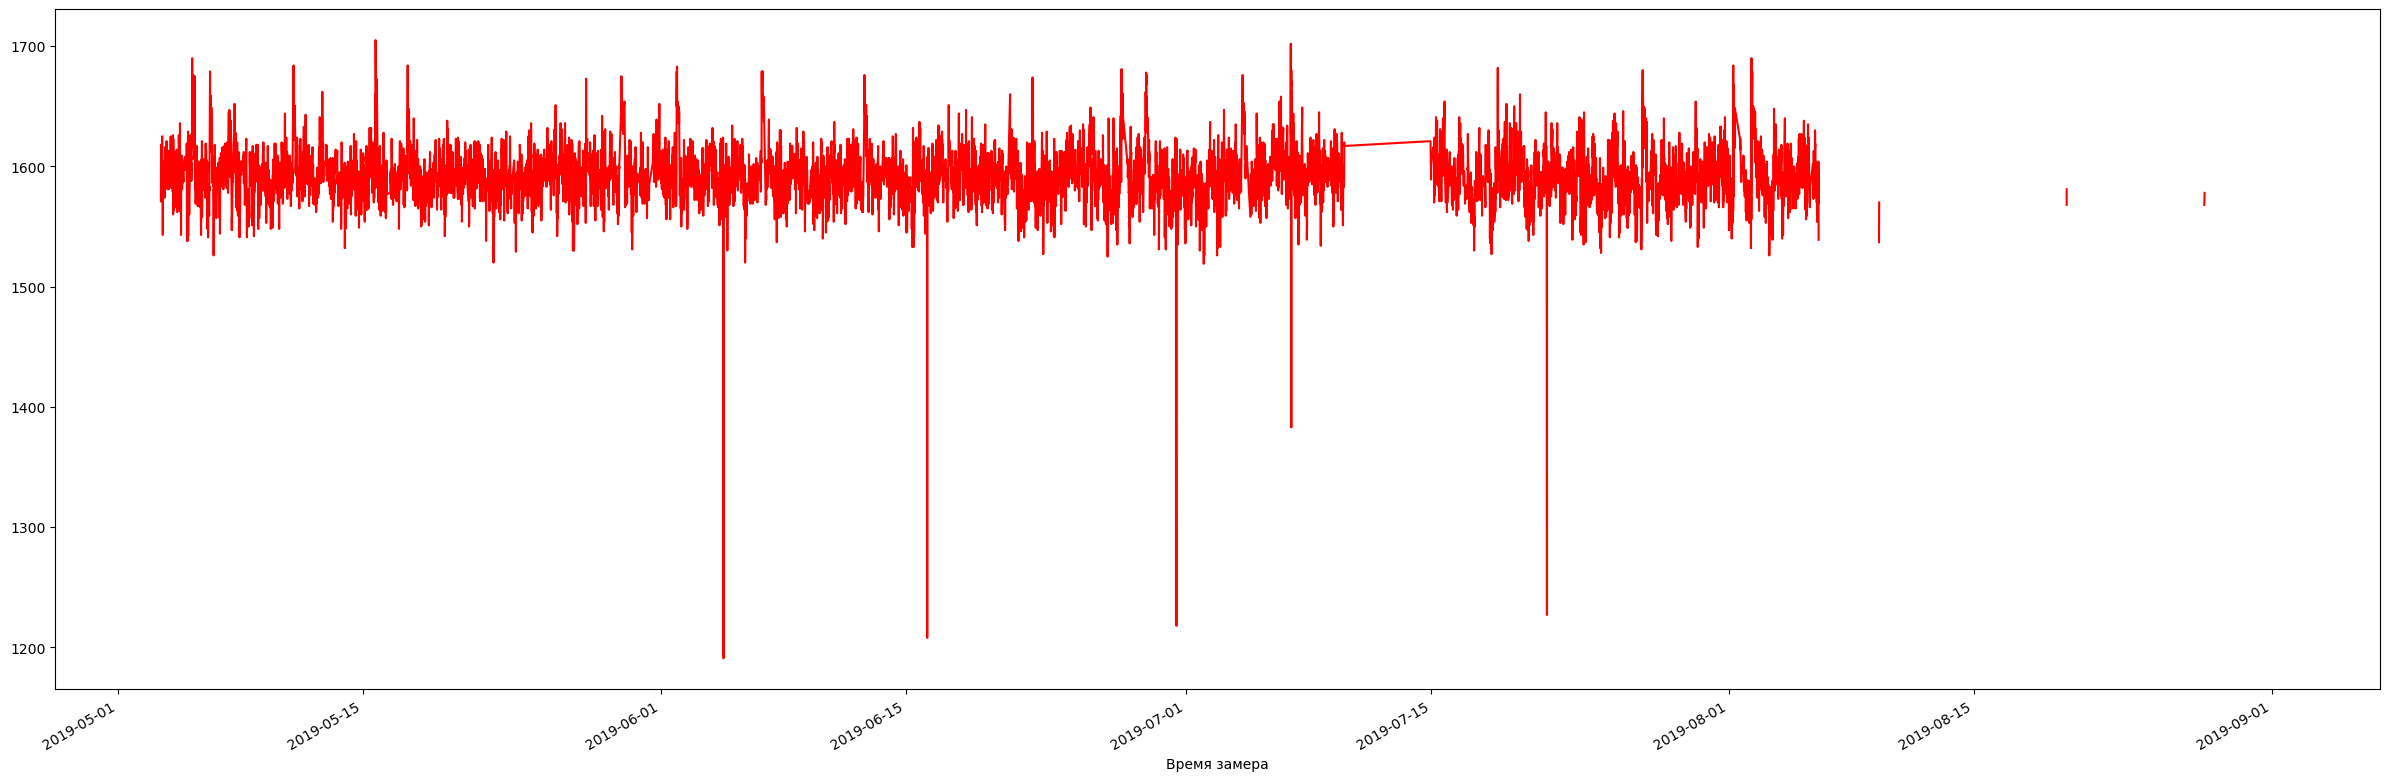

In [15]:
# Рассмотрим распределение пропусков во времени:
data_temp['Время замера'] = pd.to_datetime(data_temp['Время замера'])
print('\033[1m Распределение данных о температурах по оси времени:   \033[0m')
data_temp.set_index('Время замера')['Температура'].plot(figsize=(30, 10), color='r')
plt.show()

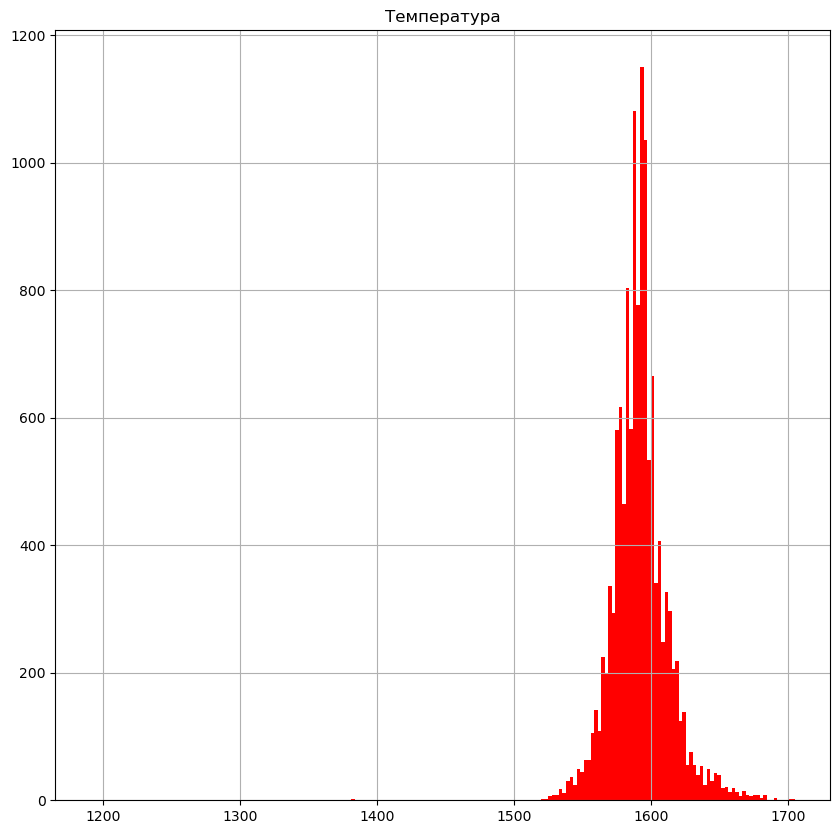

In [16]:
# Гистограмма распределений температур:
data_temp.hist(column='Температура', figsize=(10,10), bins=200, color='r')
plt.show()

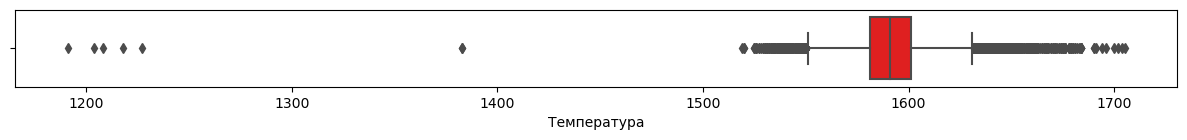

In [17]:
# Ящик с усами:

build_boxplots(data_temp.drop(columns=['key', 'Время замера']), 'r')

1) Объекты data_temp соответствуют объектам из data_arc. 

2) Имеется 2901 пропуск. Пропуски распределены не случайно, а в основном относятся к последнему месяцу выборки (август 2019). Иногда отсутствует последняя температура, но присутствует предшествующая - отсюда делаем вывод о том, что удалять пропуски непосредственно из этого датафрейма нельзя (это вызовет смещение выборки - предпоследние результаты станут последними, т.е. мы самопроизвольно добавим "известные" целевые признаки, что негативно скажется на работе с новыми данными. Поэтому удалять пропуски будем уже на сведённой таблице.

3) По условию задачи нам запрещено использовать промежуточные значения температур. При объединении датафреймов будут сохранены только первое и последнее значения.

По гистограмме и диаграмме размаха:

4) Распределение показателя температуры близко к нормальному, унимодально, сильно смещено вправо (это "благодаря" выбросам влево).



<a id='3'></a>
### 1.3 Данные о продувке сплава газом (data_gas)

In [18]:
# Поглянем на данные о продувке сплава газом: 

data_gas.head(3)

,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793


In [19]:

data_gas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


In [20]:
print('Информация о пропусках по колонкам: ')
data_gas.isna().sum()

Информация о пропусках по колонкам: 


key      0
Газ 1    0
dtype: int64

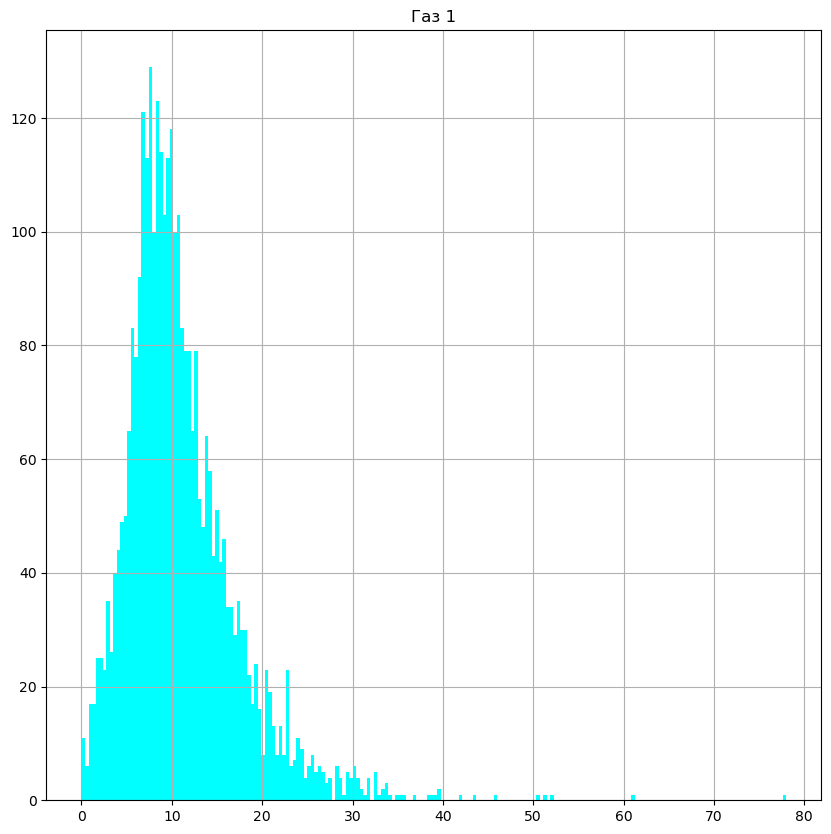

In [21]:
# Гистограмма распределений данных об объеме газа:
data_gas.hist(column='Газ 1', figsize=(10,10), bins=200, color='aqua')
plt.show()

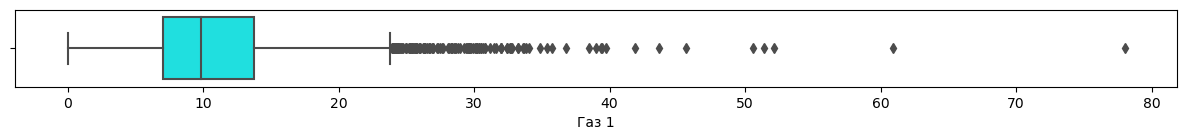

In [22]:
# Ящик с усами:

build_boxplots(data_gas.drop(columns=['key']), 'aqua')

1) Число объектов в data_gas сответствует числу партий. Пропусков не обнаружено.

2) Распределение симметрично, унимодально, смещено влево (выбросы).

<a id='4'></a>
### 1.4 Данные о подаче сыпучих материалов (data_arc)

In [23]:
# Взглянем на данные о подаче сыпучих материалов:

data_bulk.head(3)

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0


In [24]:
data_bulk.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


In [25]:
print('Информация о пропусках по колонкам: ')
data_bulk.isna().sum()

Информация о пропусках по колонкам: 


key           0
Bulk 1     2877
Bulk 2     3107
Bulk 3     1831
Bulk 4     2115
Bulk 5     3052
Bulk 6     2553
Bulk 7     3104
Bulk 8     3128
Bulk 9     3110
Bulk 10    2953
Bulk 11    2952
Bulk 12     679
Bulk 13    3111
Bulk 14     323
Bulk 15     881
dtype: int64

Гистограмма распределений данных об объеме сыпучих добавок с нулями вместо пропусков:


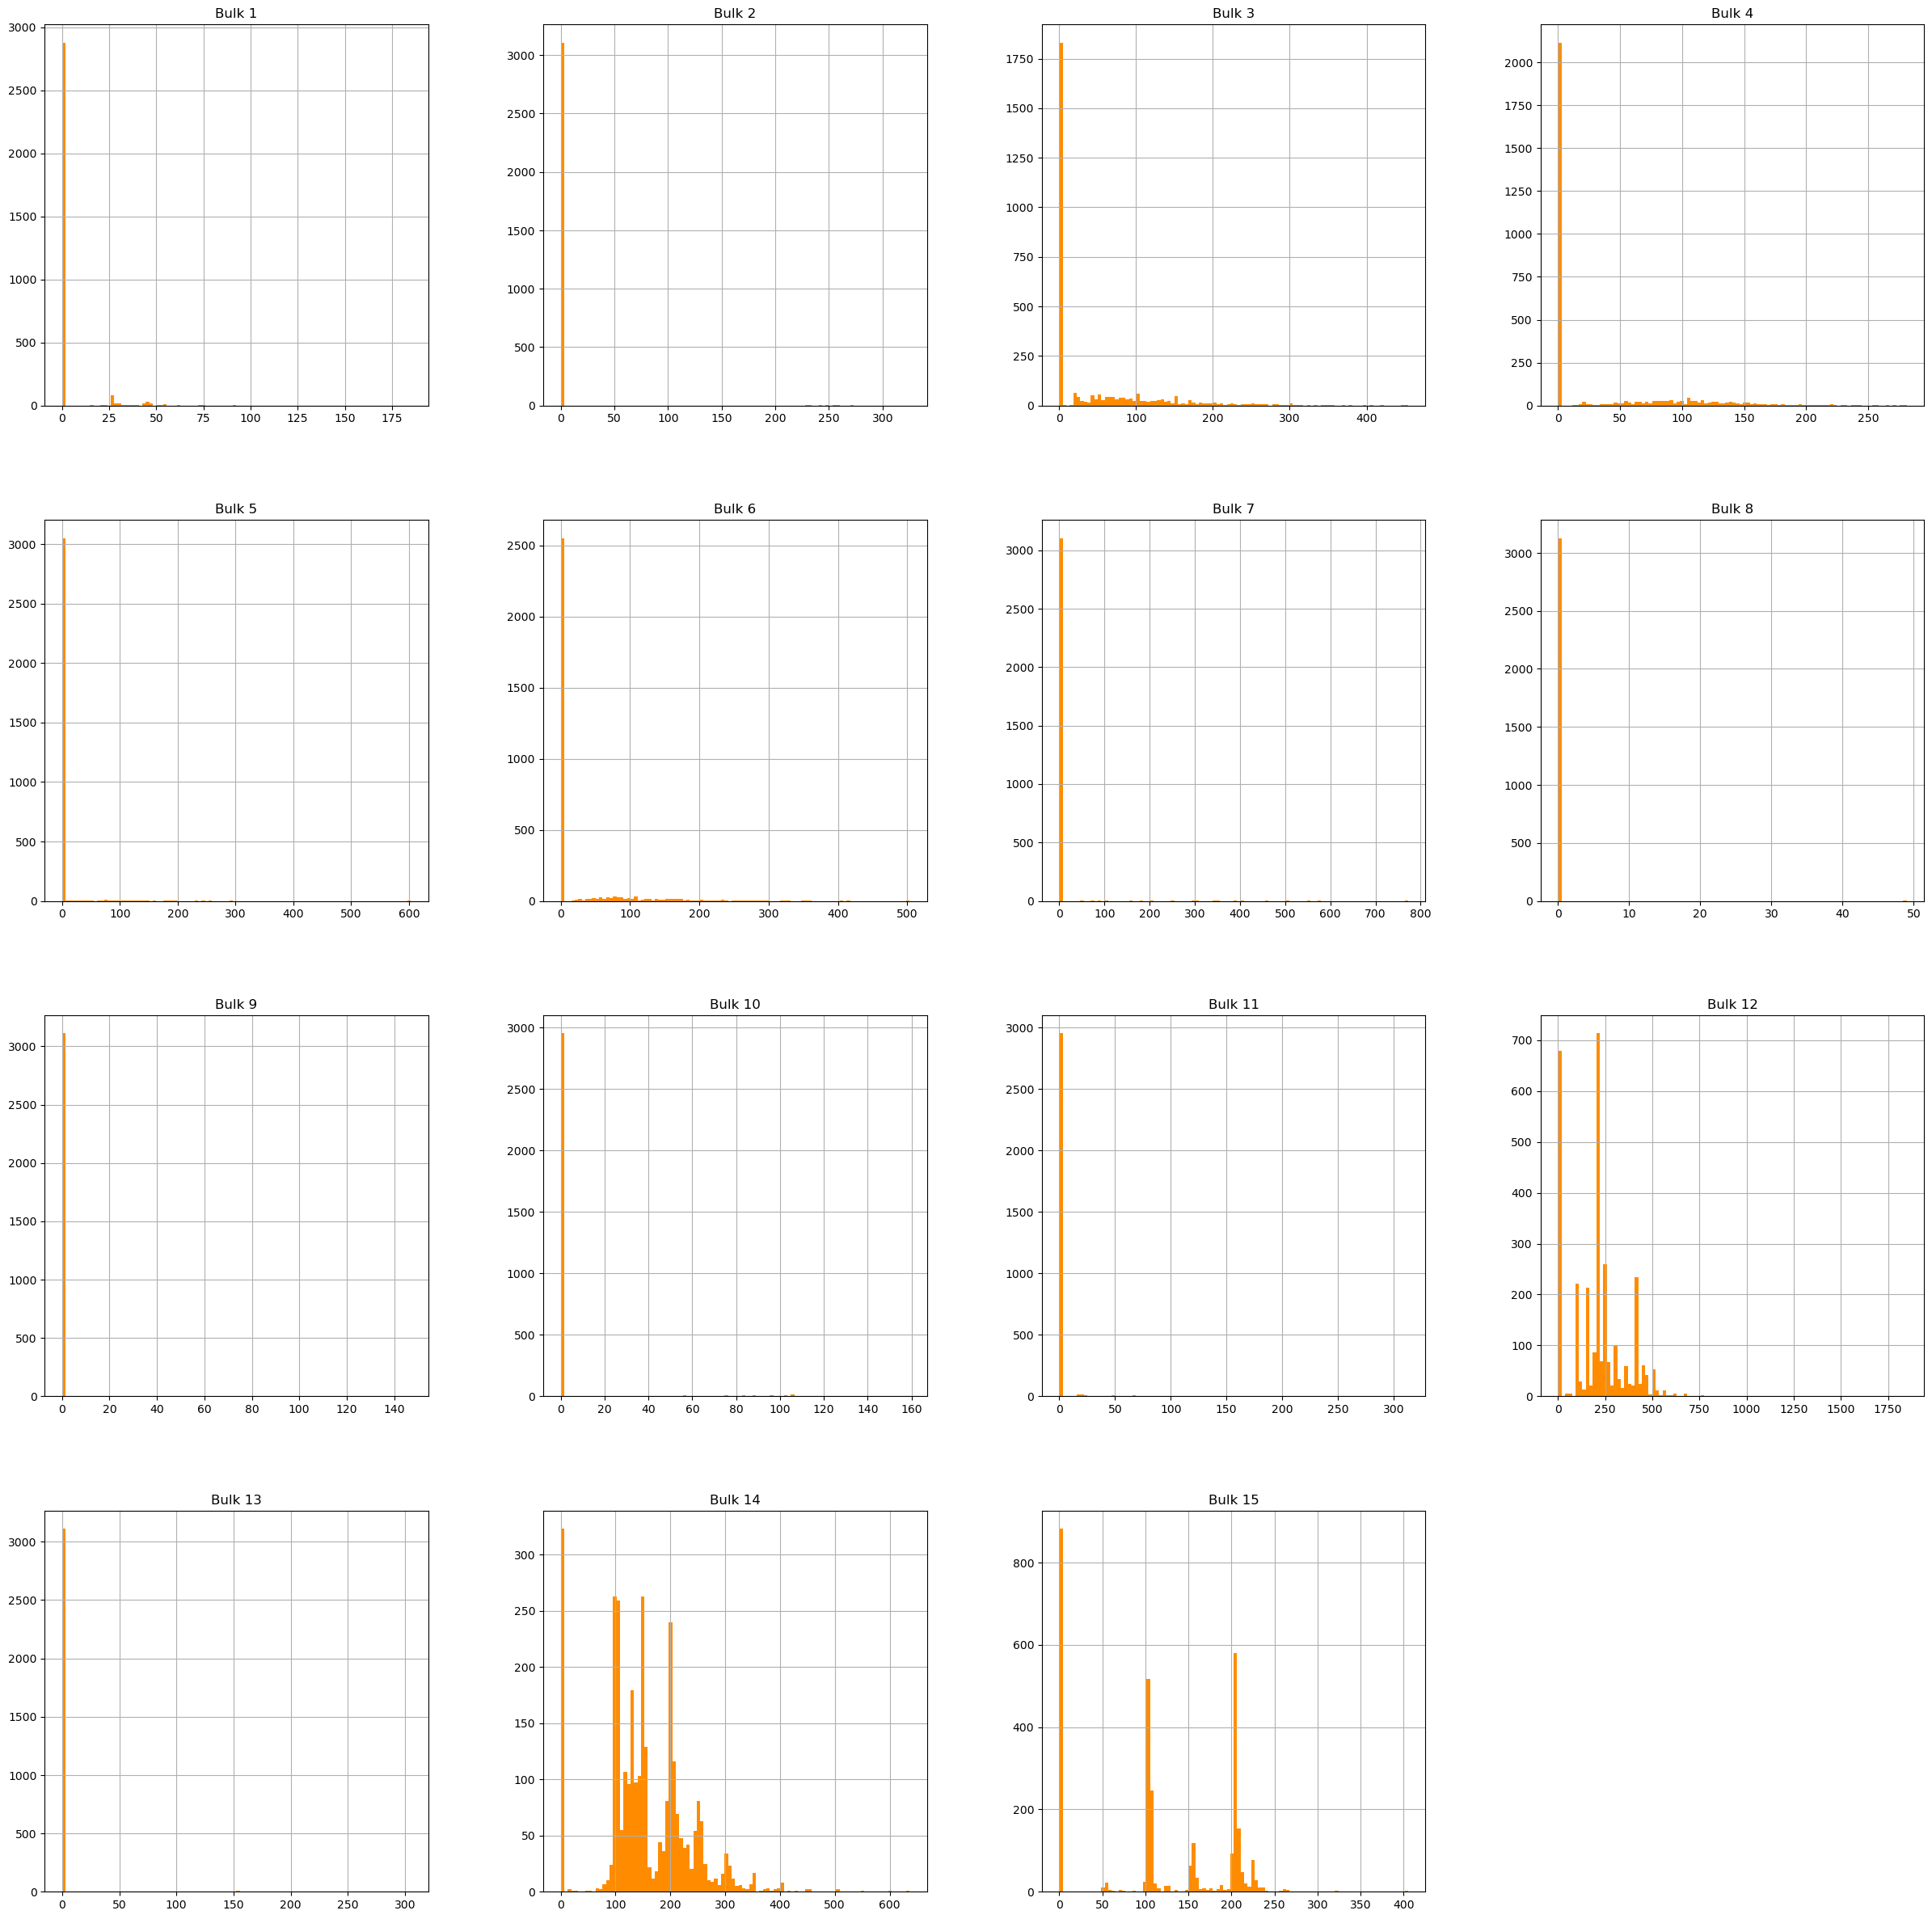

In [26]:
# Гистограмма распределений данных об объеме сыпучих добавок с нулями вместо пропусков:
print('Гистограмма распределений данных об объеме сыпучих добавок с нулями вместо пропусков:')

(data_bulk).fillna(0).drop(columns=['key']).hist(figsize=(30,30), bins=100, color='darkorange')
plt.show()

Гистограмма распределений данных об объеме сыпучих добавок без учёта нулевых значений:


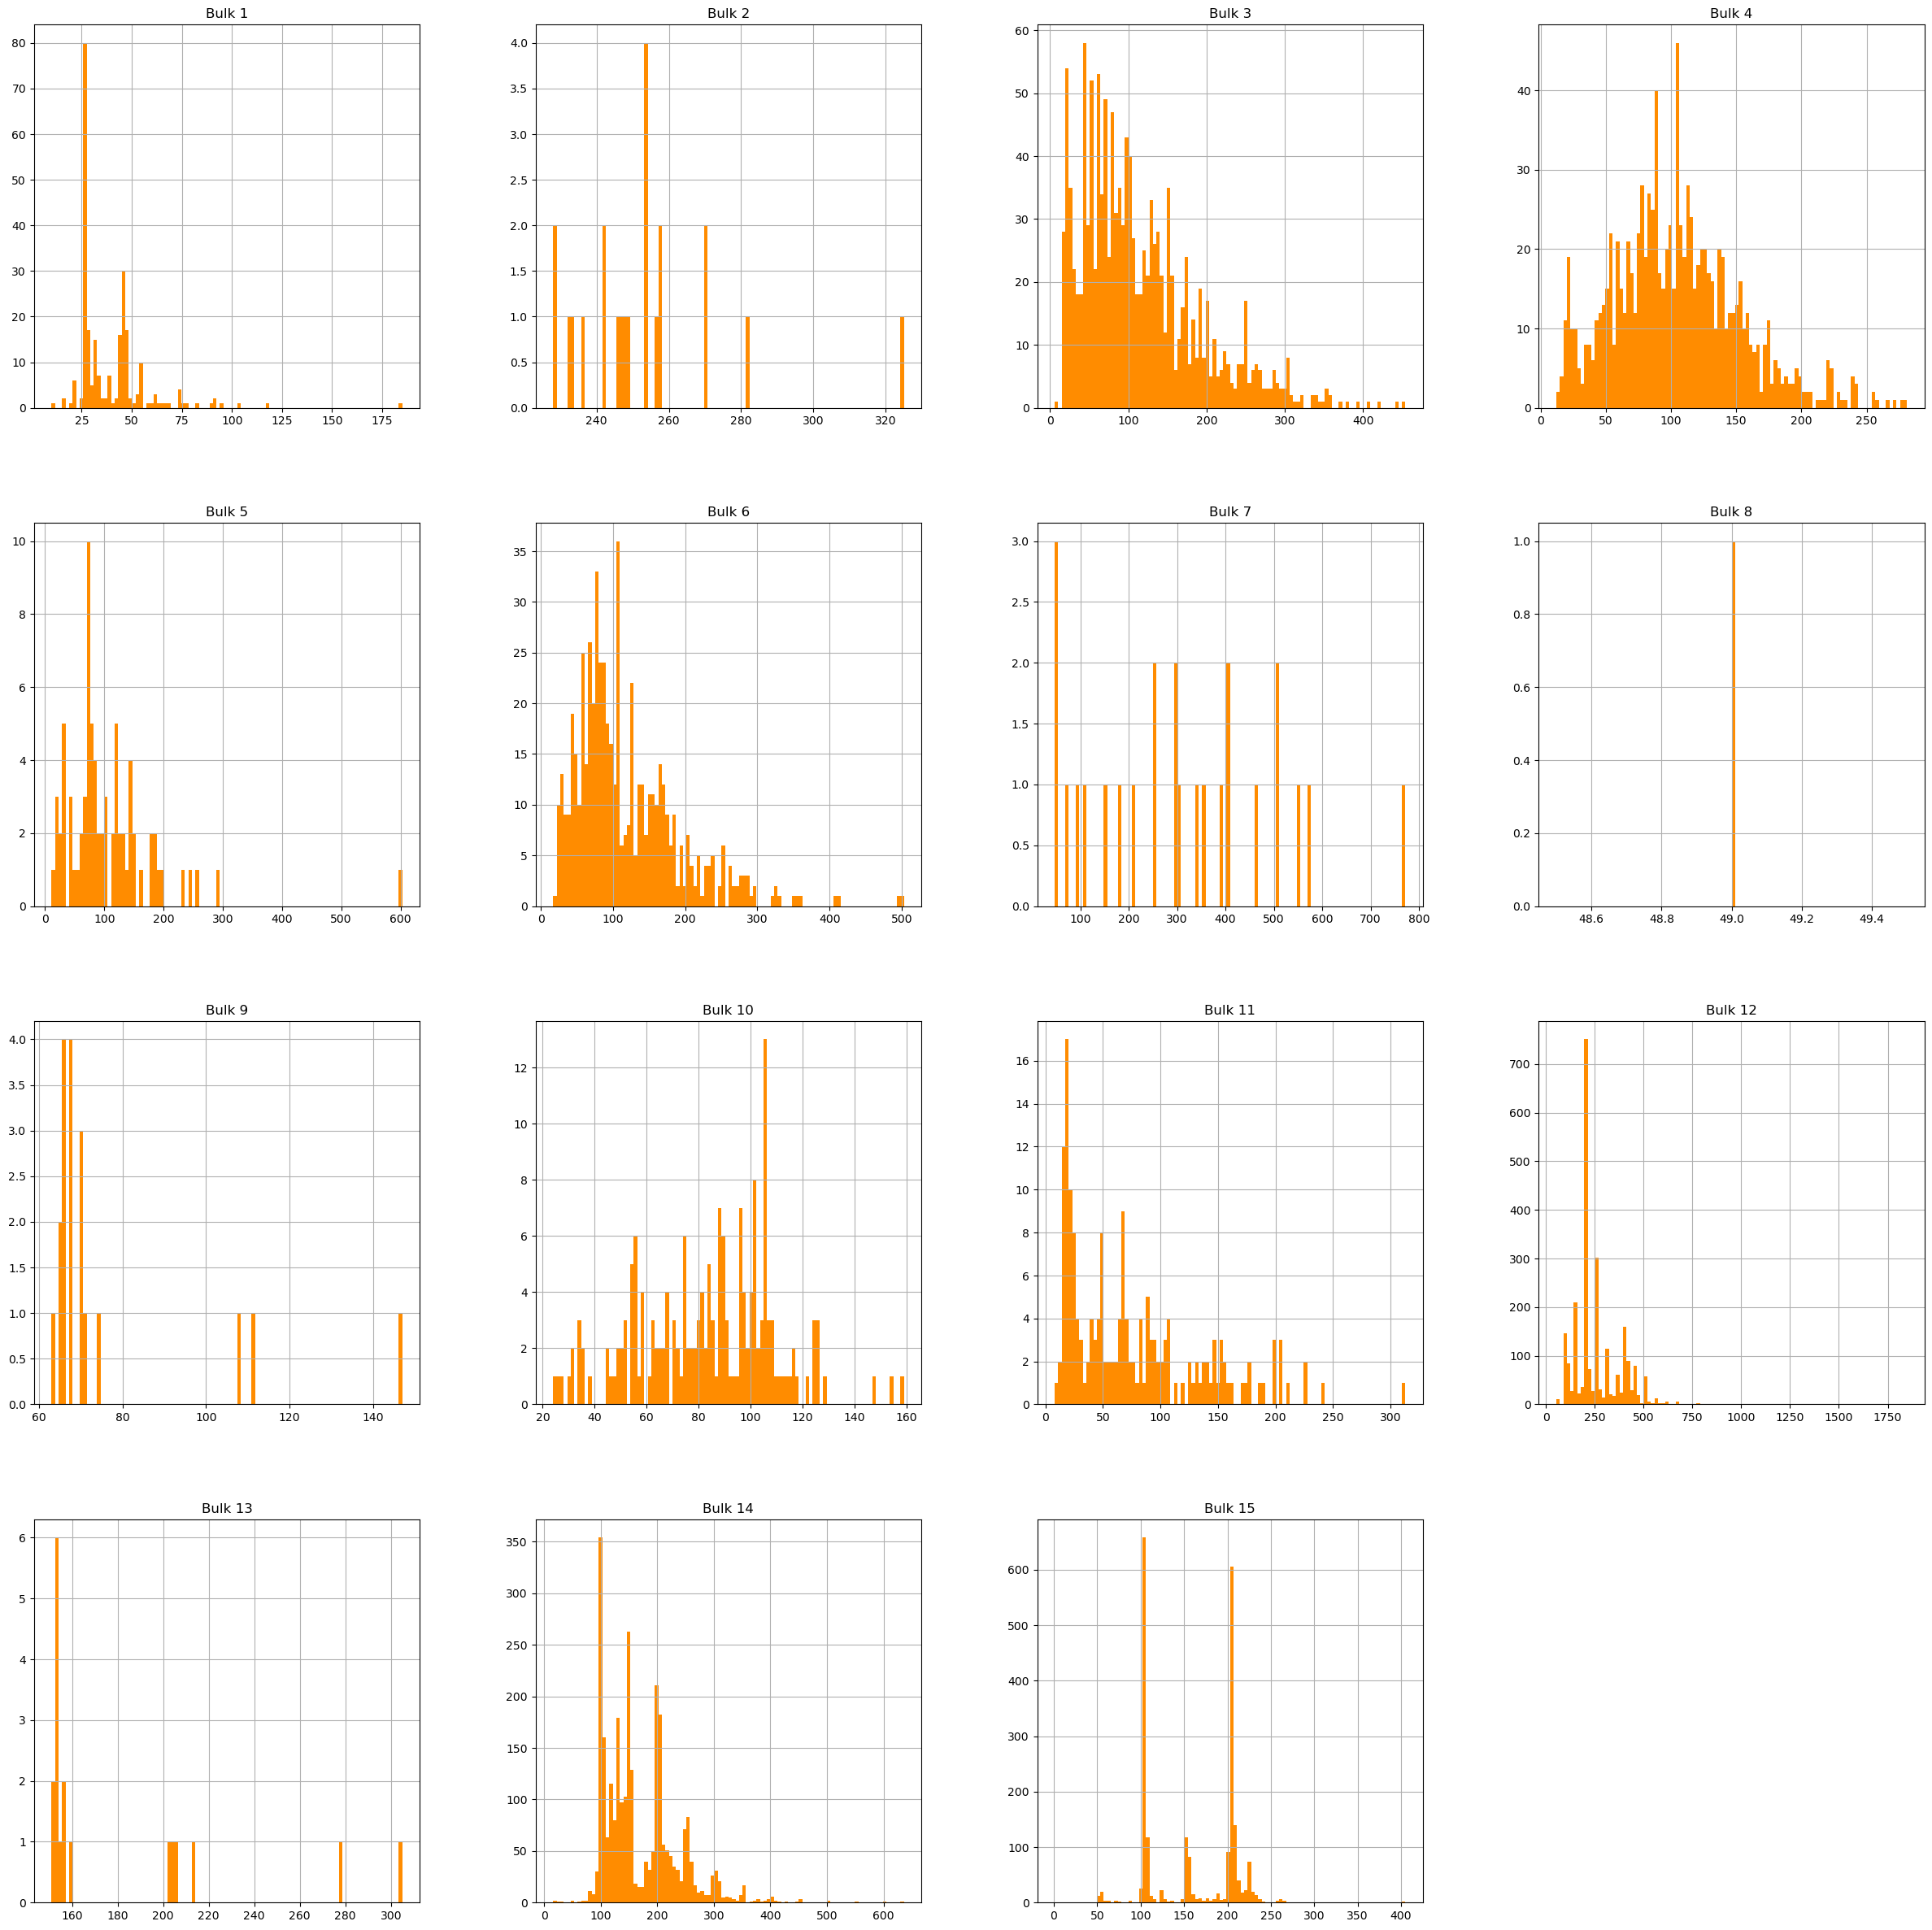

In [27]:
# Гистограмма распределений данных об объеме сыпучих добавок без учёта нулевых значений:
print('Гистограмма распределений данных об объеме сыпучих добавок без учёта нулевых значений:')

data_bulk.drop(columns=['key']).hist(figsize=(30,30), bins=100, color='darkorange')
plt.show()

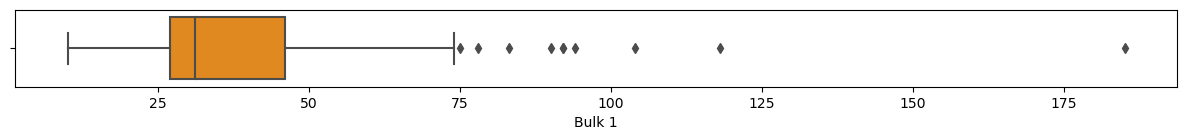

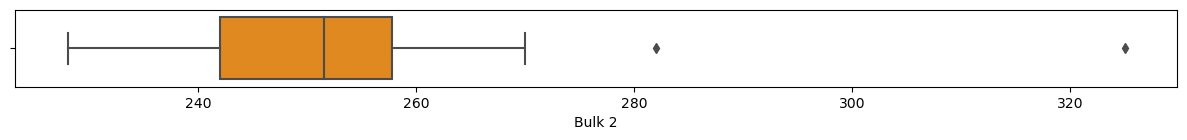

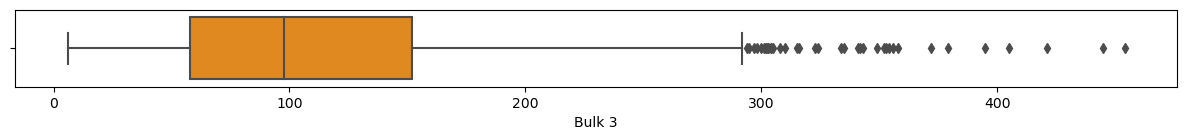

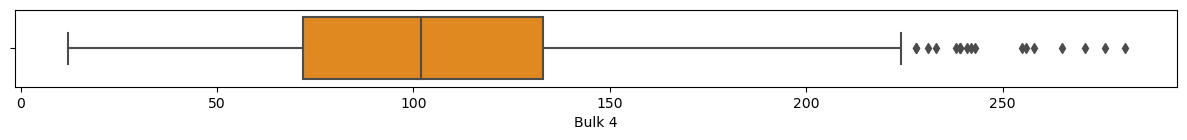

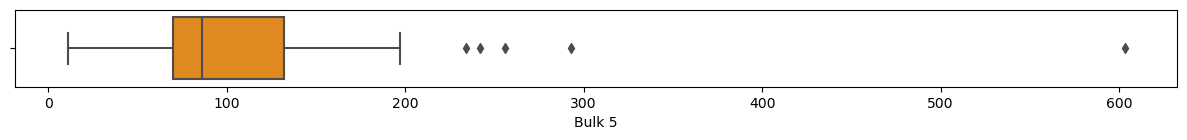

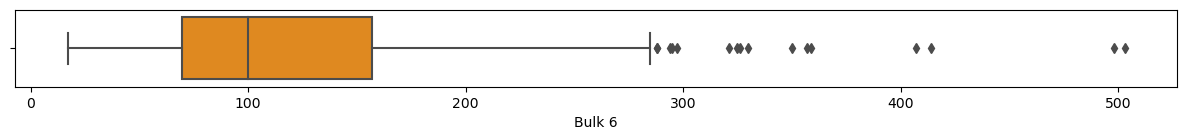

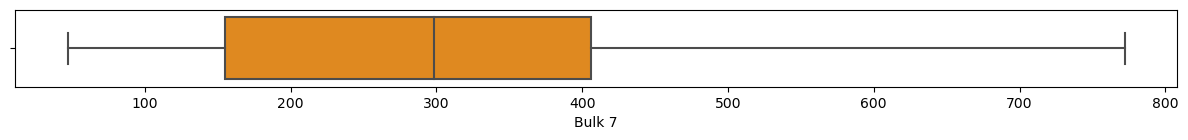

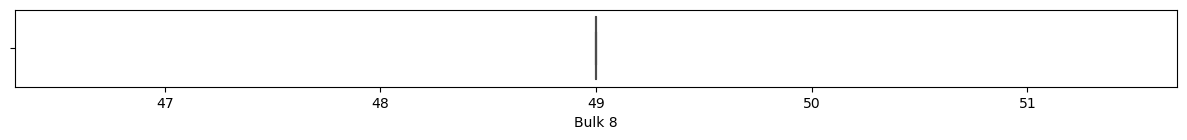

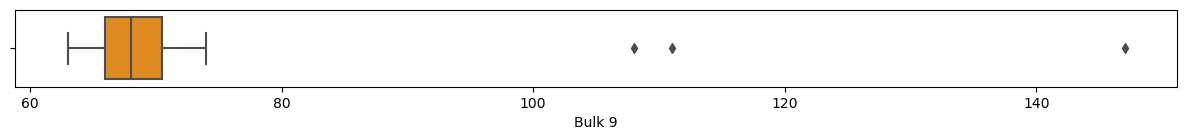

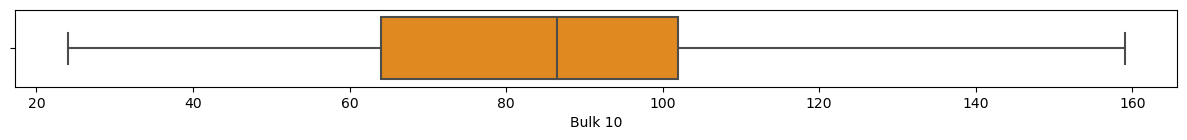

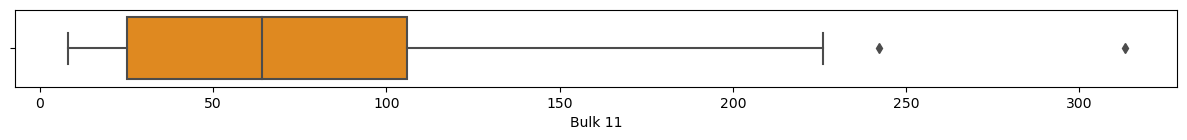

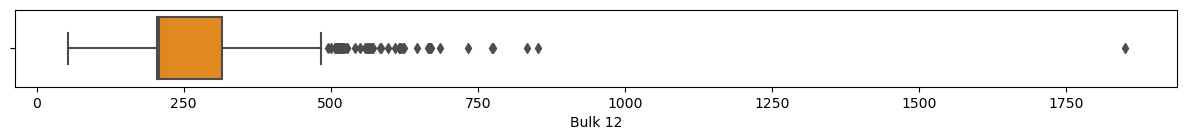

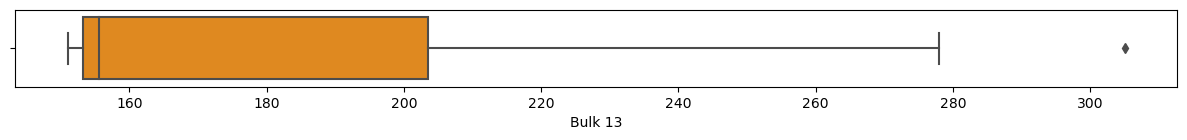

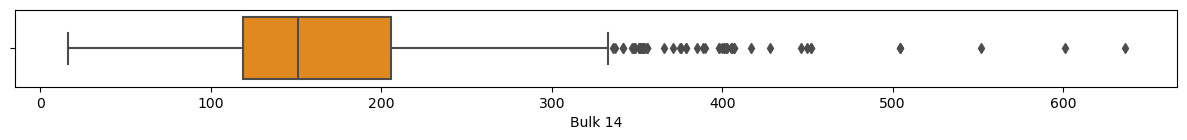

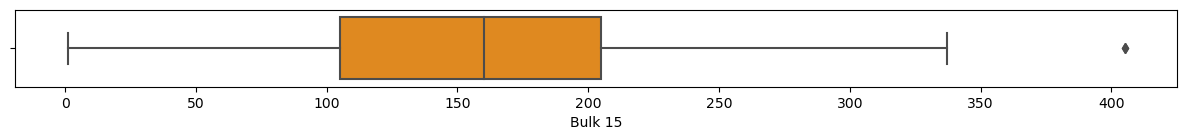

In [28]:
# Ящик с усами:

build_boxplots(data_bulk.drop(columns=['key']), 'darkorange')

1) Имеем 15 различных добавок. Число объектов в датафрейме приблизительно соответствует числу партий за рассматриваемый период. 

2) Пропусков много. Мы полагаем, они обусловлены тем, что для различных сплавов используются различные примеси. Исходя из этого, пропуски будут заполнены нулями на этапе предобработки.

3) Распределения объемов добавок едва ли напоминают нормальные. Предположительно, это связано с недостаточностью данных. Наличествуют выбросы, все они смещают распределения признаков влево.

4) Для признака 'Bulk 8' имеется всего лишь одно значение. Вероятно, наилучшим реением будет избавиться от этого признака.

<a id='5'></a>
### 1.5 Данные о подаче проволочных материалов (data_wire)

In [29]:
# Взглянем на данные о подаче проволочных материалов:

data_wire.head(3)

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [30]:
data_wire.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


In [31]:
print('Число пропусков по колонкам: ')
data_wire.isna().sum()

Число пропусков по колонкам: 


key          0
Wire 1      26
Wire 2    2002
Wire 3    3018
Wire 4    3067
Wire 5    3080
Wire 6    3008
Wire 7    3070
Wire 8    3062
Wire 9    3052
dtype: int64

Гистограмма распределений данных об объеме проволоки без учёта нулевых значений: 


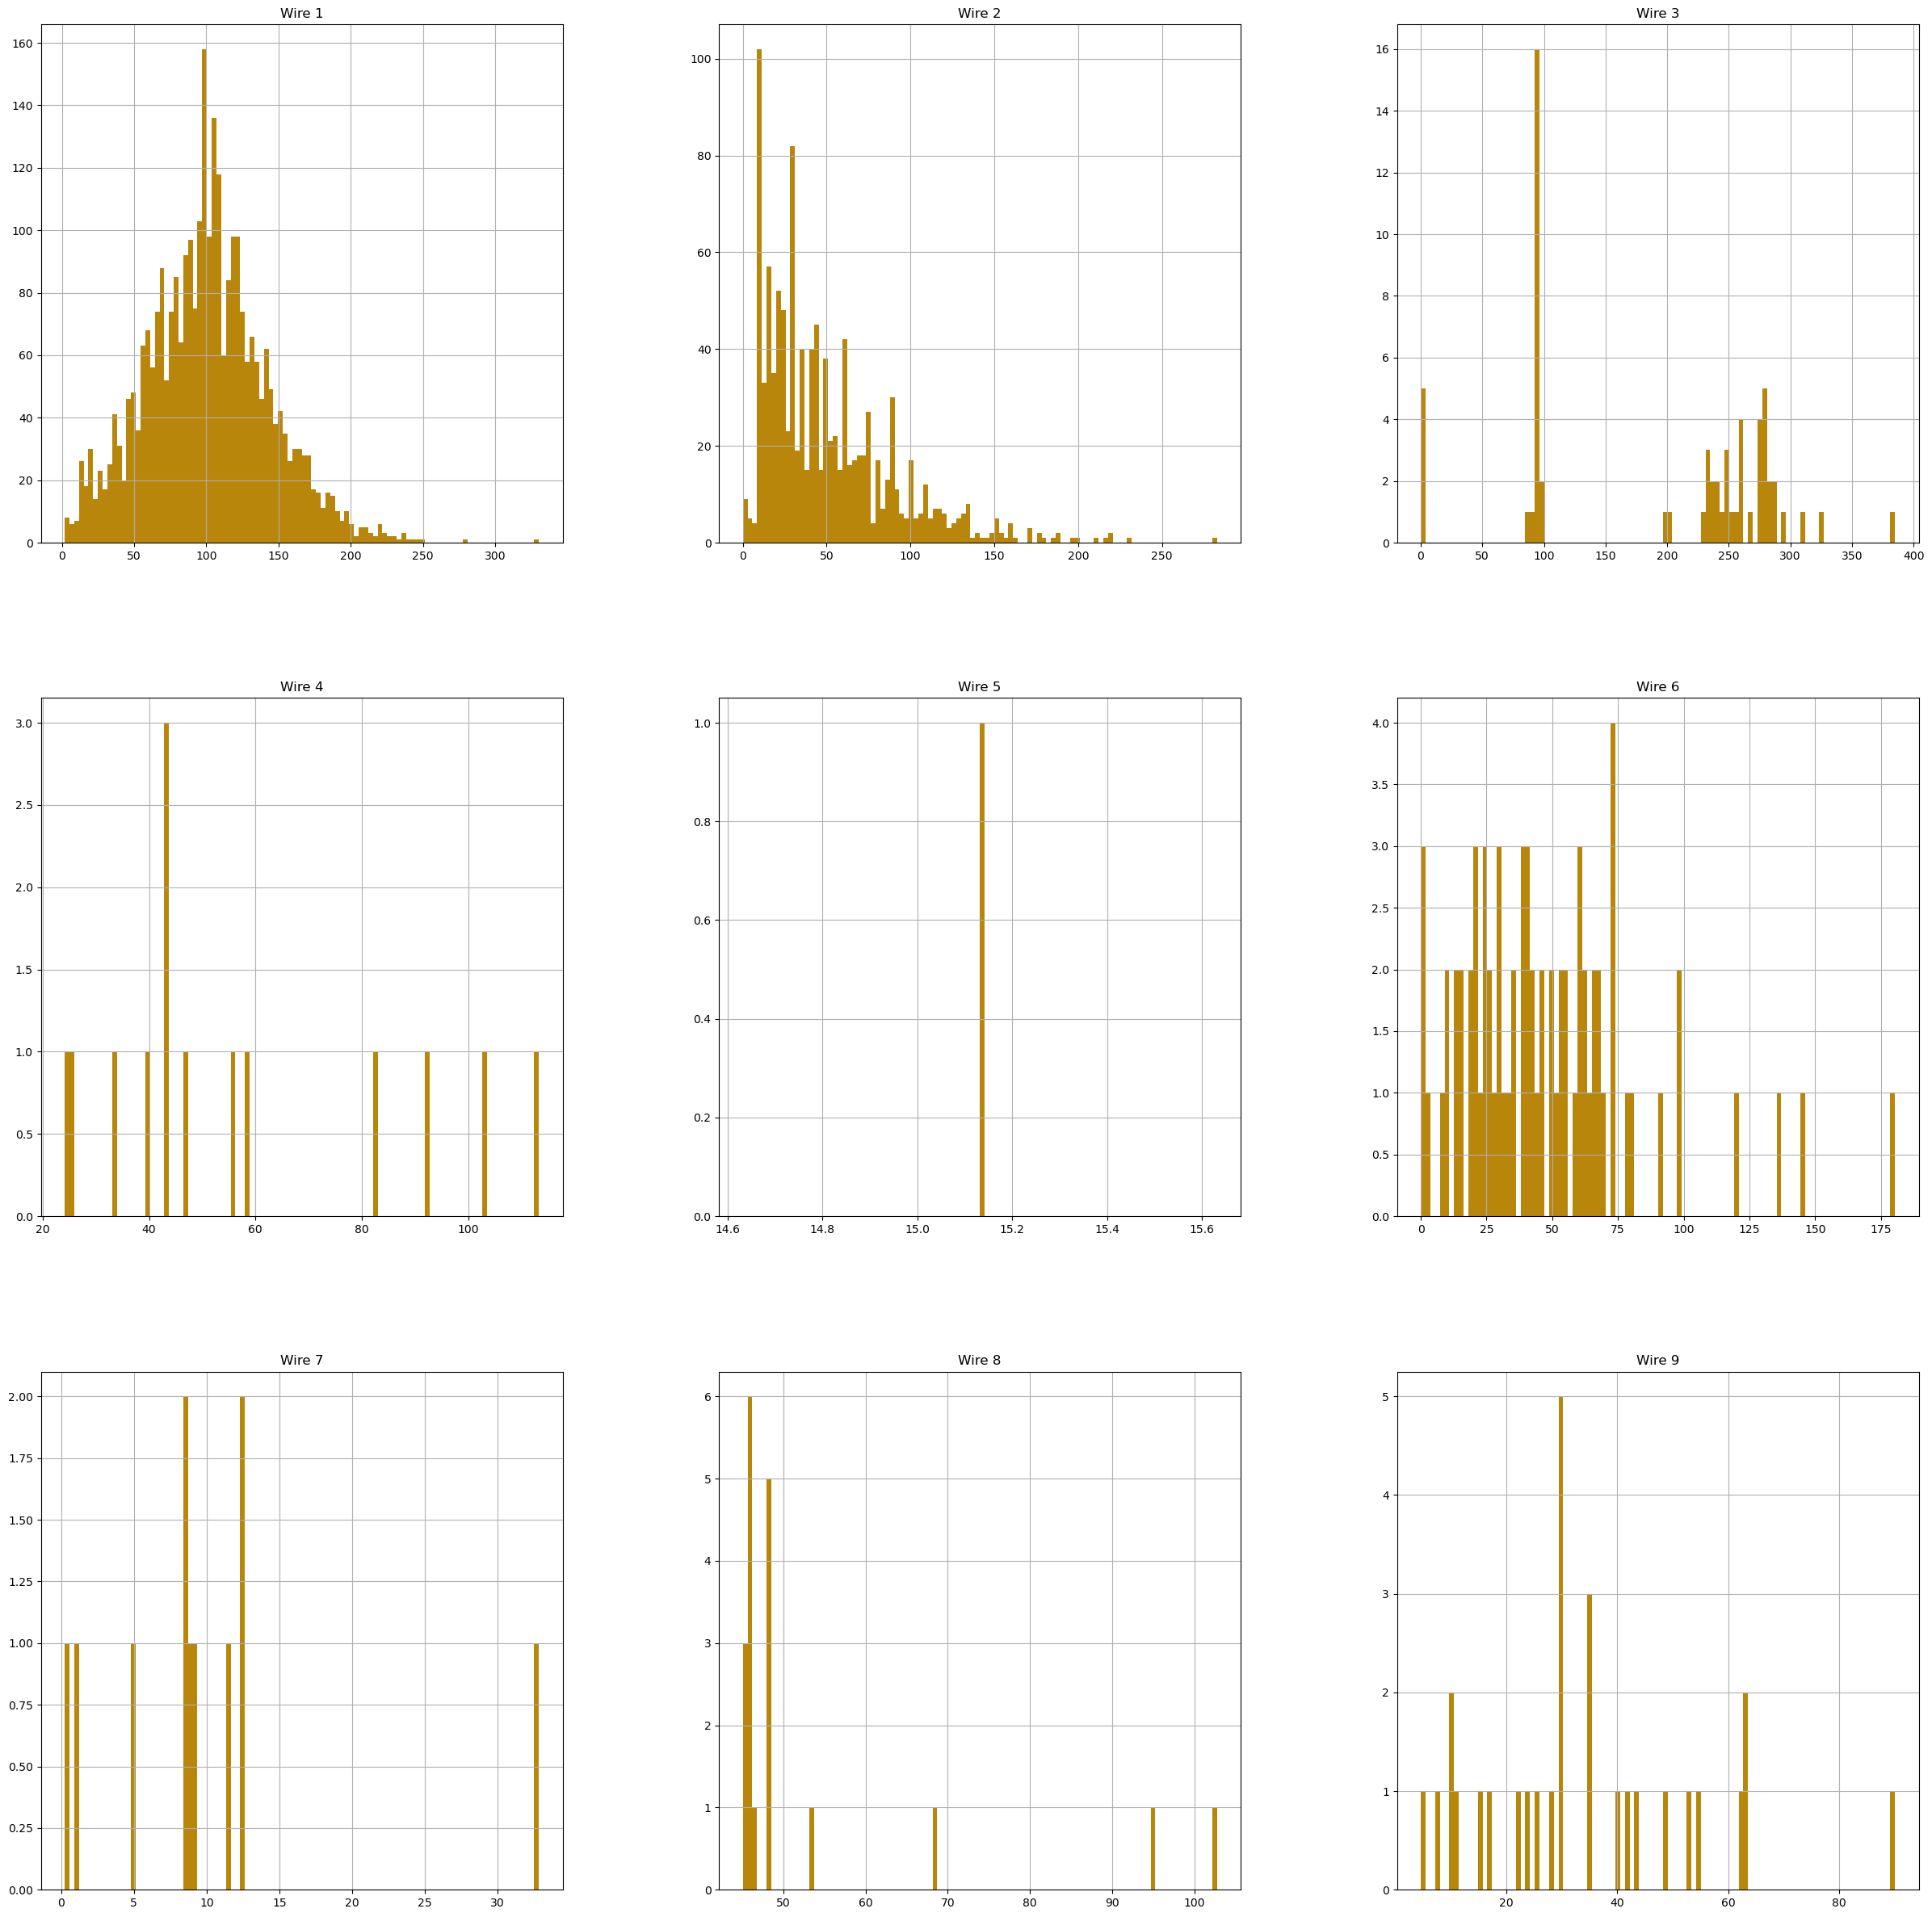

In [32]:
# Гистограмма распределений данных об объеме проволоки без учёта нулевых значений:
print('Гистограмма распределений данных об объеме проволоки без учёта нулевых значений: ')
(data_wire).drop(columns=['key']).hist(figsize=(30,30), bins=100, color='darkgoldenrod')
plt.show()

Гистограмма распределений данных об объеме проволоки с нулями вместо пропусков:


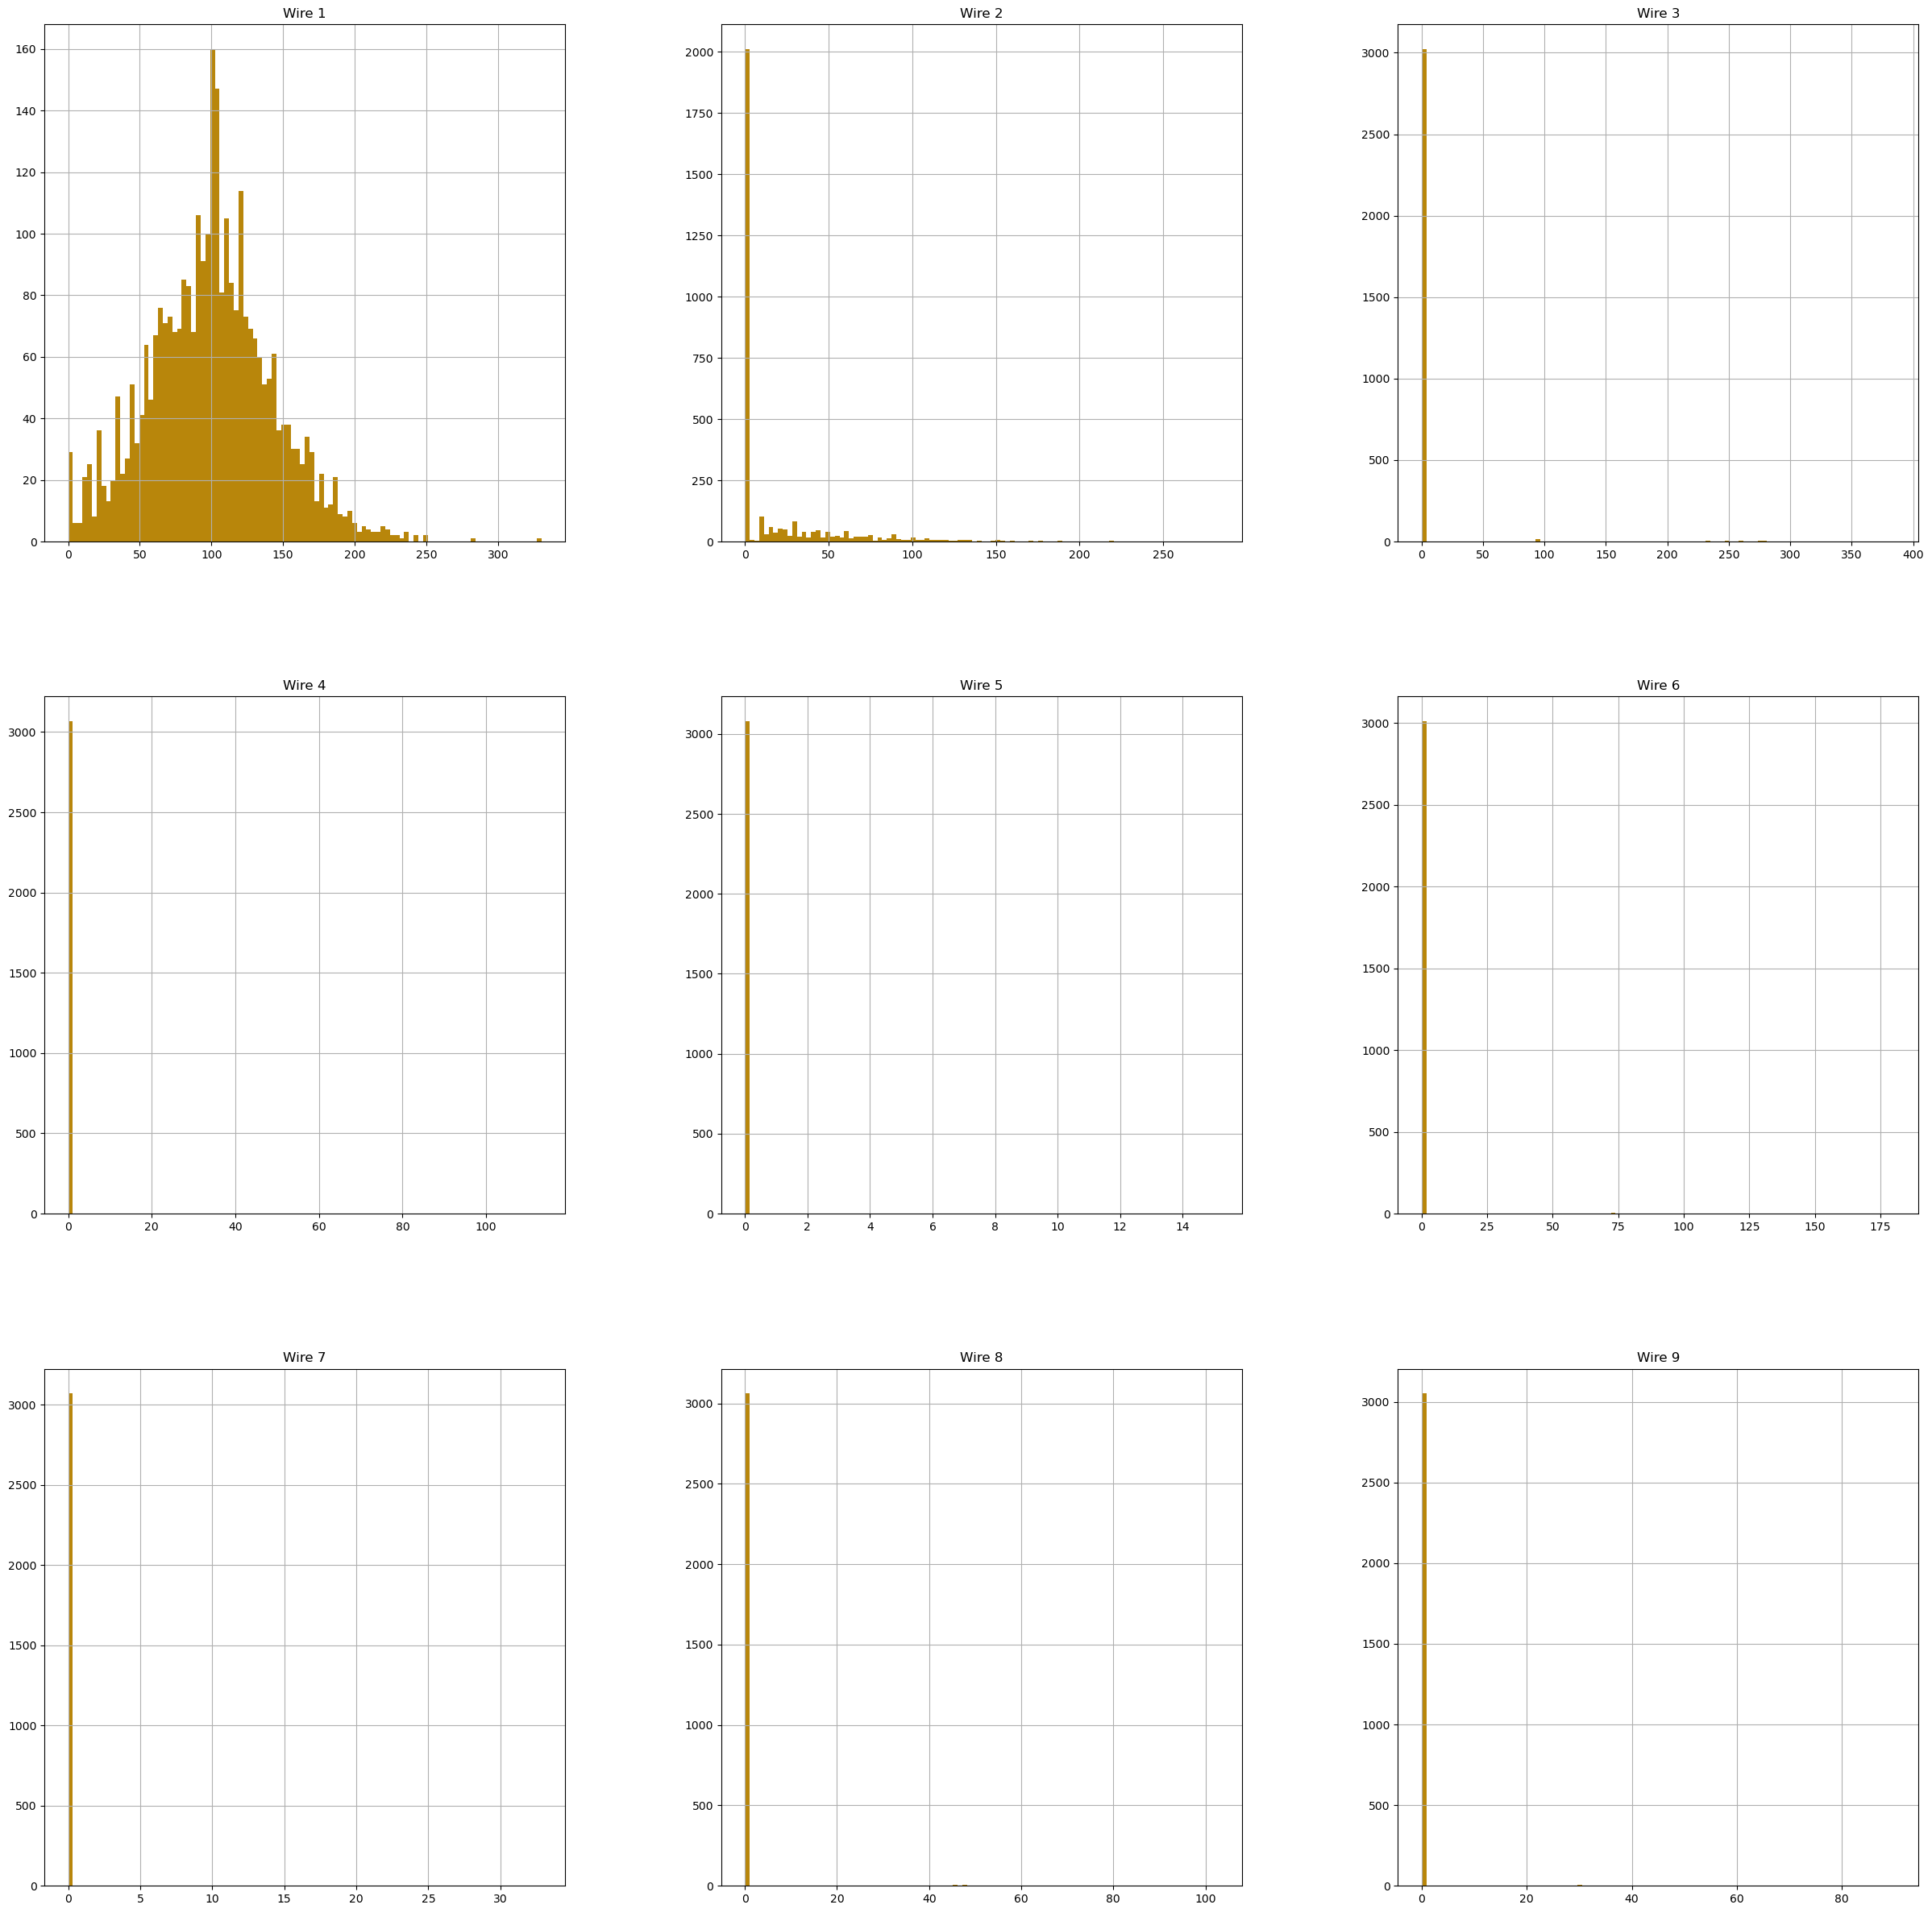

In [33]:
# Гистограмма распределений данных об объеме проволоки с нулями вместо пропусков:
print('Гистограмма распределений данных об объеме проволоки с нулями вместо пропусков:')

(data_wire).fillna(0).drop(columns=['key']).hist(figsize=(30,30), bins=100, color='darkgoldenrod')
plt.show()

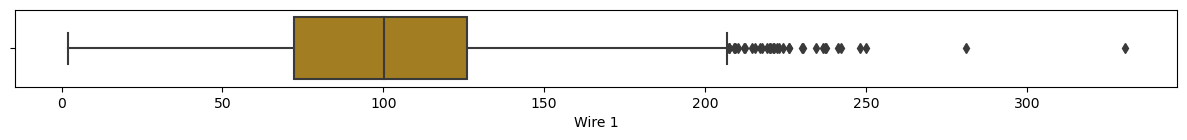

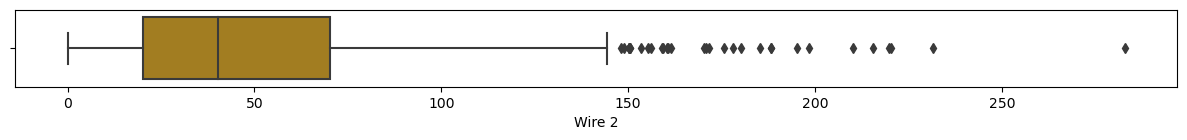

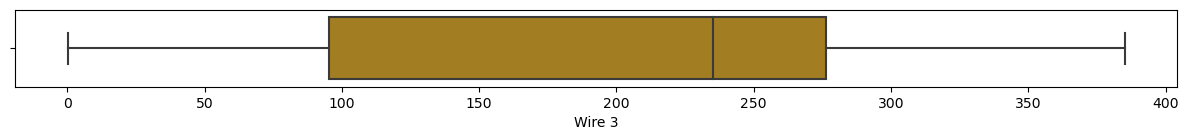

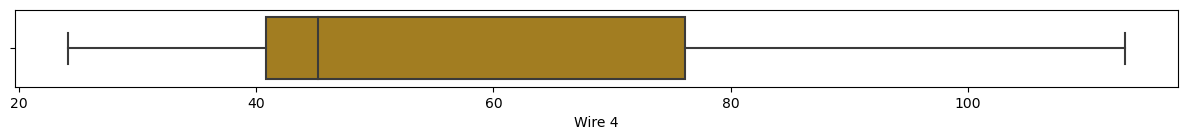

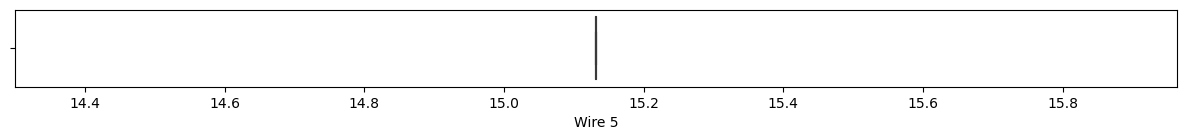

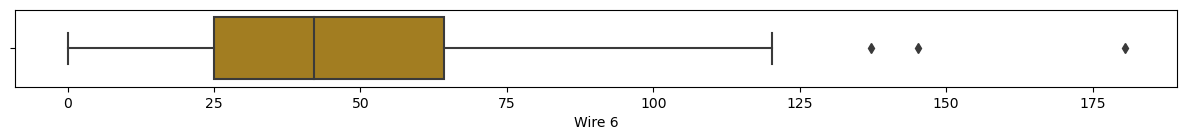

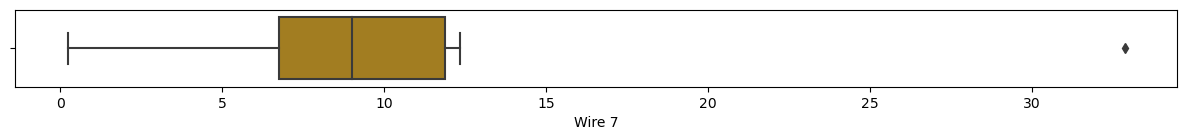

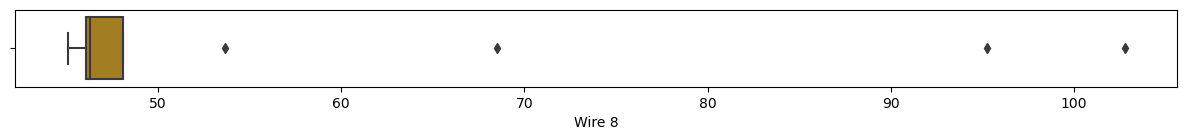

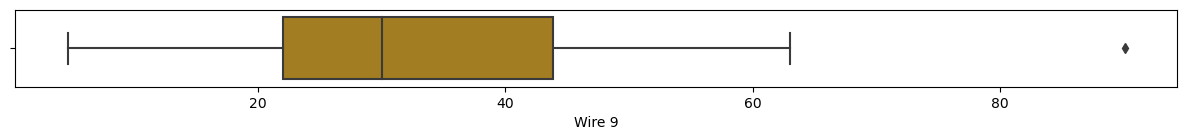

In [34]:
# Ящик с усами:

build_boxplots(data_wire.drop(columns=['key']), 'darkgoldenrod')

1) Имеем 9 различных типов проволоки. Число объектов в датафрейме приблизительно соответствует числу партий за рассматриваемый период.


2) Пропуска обусловлены теми же причинами и могут быть заполнены теми же способами, что и для data_bulk.

3) Большая часть распределений (при заполнении пропусков нулями) смещена влево, это связано с большим количеством нулей. Чаще всего встречаются 'Wire 1' и 'Wire 2'. 

4) Прочие признаки встречаются очень ограниченное число раз, 'Wire 4' встречается всего один раз. От него, вероятно, предстоит избавиться.



<a id='6'></a>
### 1.6 Прочие

In [35]:
data_bulk_time

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,2019-05-03 11:21:30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:03:52,NaN,2019-05-03 11:03:52,2019-05-03 11:03:52
1,2,NaN,NaN,NaN,2019-05-03 11:46:38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:40:20,NaN,2019-05-03 11:40:20,2019-05-03 11:40:20
2,3,NaN,NaN,NaN,2019-05-03 12:31:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:09:40,NaN,2019-05-03 12:09:40,2019-05-03 12:09:40
3,4,NaN,NaN,NaN,2019-05-03 12:48:43,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:41:24,NaN,2019-05-03 12:41:24,2019-05-03 12:41:24
4,5,NaN,NaN,NaN,2019-05-03 13:18:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:12:56,NaN,2019-05-03 13:12:56,2019-05-03 13:12:56
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3124,3237,NaN,NaN,2019-08-31 22:51:28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-08-31 22:46:52,NaN,2019-08-31 22:46:52,2019-08-31 22:46:52
3125,3238,NaN,NaN,2019-08-31 23:39:11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-08-31 23:33:09,NaN,2019-08-31 23:33:09,2019-08-31 23:33:09
3126,3239,NaN,NaN,NaN,NaN,NaN,2019-09-01 01:51:58,NaN,NaN,NaN,NaN,NaN,2019-09-01 01:39:41,NaN,2019-09-01 01:33:25,2019-09-01 01:33:25
3127,3240,NaN,NaN,NaN,NaN,NaN,2019-09-01 03:12:40,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-09-01 02:41:27,2019-09-01 02:41:27


In [36]:
data_wire_time

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:11:41,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2019-05-03 11:46:10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2019-05-03 12:13:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2019-05-03 12:48:05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2019-05-03 13:18:15,2019-05-03 13:32:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
3076,3237,2019-08-31 22:50:20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3077,3238,2019-08-31 23:38:24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3078,3239,2019-09-01 01:50:43,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3079,3240,2019-09-01 03:12:02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


1) Оба датафрейма содержат данные о времени помещения добавок в расплав и не могут быть задействованы в решении рассматриваемой задачи. В первом приближении эти два датафрейма нам ни к чему.

### План действий

Нам предстоит:

1) Объединить имеющиеся датафреймы с максимальным сохранением имеющихся в них информации (за исключением промежуточных температур) в один.

2) Произвести обработку нового датафрейма (удаление и заполнение пропусков, генерация новых признаков и т.п.

3) Использовать модели машинного обучения для достижения требуемой по условию задачи метрики.

## 2. Предобработка и "склеивание" датафрейма

<a id='7'></a>
### 2.1 Собираем данные в один датафрейм

In [37]:
# Сведём данные о суммарной мощности за каждую партию:

data_lst_arc = data_arc.groupby(by = 'key', as_index = False).sum()


data_lst_arc

,key,Активная мощность,Реактивная мощность,Длительность нагрева
0,1,4.878147,3.183241,1098
1,2,3.052598,1.998112,811
2,3,2.525882,1.599076,655
3,4,3.209250,2.060298,741
4,5,3.347173,2.252643,869
...,...,...,...,...
3209,3237,3.932467,2.828459,909
3210,3238,2.106529,1.681182,546
3211,3239,4.666754,3.111617,1216
3212,3240,2.984083,2.483267,839


In [38]:
# Аналогично поступим и с данными об измерении температуры:

data_lst_temp = data_temp.sort_values('Время замера').drop_duplicates(['key'], keep='last')

data_lst_temp.head(5)

,key,Время замера,Температура
4,1,2019-05-03 11:30:39,1613.0
10,2,2019-05-03 11:59:12,1602.0
15,3,2019-05-03 12:34:57,1599.0
18,4,2019-05-03 12:59:25,1625.0
20,5,2019-05-03 13:36:01,1602.0


In [39]:
#Добавим данные о начальной температуре и времени первого замера:

first_data = data_temp.sort_values('Время замера').drop_duplicates(['key'], keep='first')[['Время замера', 'Температура']].values
data_lst_temp[['Время первого замера', 'Начальная температура']] = first_data

data_lst_temp

,key,Время замера,Температура,Время первого замера,Начальная температура
4,1,2019-05-03 11:30:39,1613.0,2019-05-03 11:16:18,1571.0
10,2,2019-05-03 11:59:12,1602.0,2019-05-03 11:37:27,1581.0
15,3,2019-05-03 12:34:57,1599.0,2019-05-03 12:13:17,1596.0
18,4,2019-05-03 12:59:25,1625.0,2019-05-03 12:52:57,1601.0
20,5,2019-05-03 13:36:01,1602.0,2019-05-03 13:23:19,1576.0
...,...,...,...,...,...
15882,3237,2019-08-31 23:05:43,NaN,2019-08-31 22:44:04,1569.0
15885,3238,2019-08-31 23:43:00,NaN,2019-08-31 23:30:31,1584.0
15893,3239,2019-09-01 02:24:15,NaN,2019-09-01 01:31:47,1598.0
15901,3240,2019-09-01 03:35:16,NaN,2019-09-01 02:39:01,1617.0


In [40]:
# Избавимся от пропусков в данных о добавках (если данные о добавке отсутствуют - наиболее вероятно, что она не вводилась ):

data_wire.fillna(0, inplace=True)
data_bulk.fillna(0, inplace=True)

In [41]:
data_lst_temp

,key,Время замера,Температура,Время первого замера,Начальная температура
4,1,2019-05-03 11:30:39,1613.0,2019-05-03 11:16:18,1571.0
10,2,2019-05-03 11:59:12,1602.0,2019-05-03 11:37:27,1581.0
15,3,2019-05-03 12:34:57,1599.0,2019-05-03 12:13:17,1596.0
18,4,2019-05-03 12:59:25,1625.0,2019-05-03 12:52:57,1601.0
20,5,2019-05-03 13:36:01,1602.0,2019-05-03 13:23:19,1576.0
...,...,...,...,...,...
15882,3237,2019-08-31 23:05:43,NaN,2019-08-31 22:44:04,1569.0
15885,3238,2019-08-31 23:43:00,NaN,2019-08-31 23:30:31,1584.0
15893,3239,2019-09-01 02:24:15,NaN,2019-09-01 01:31:47,1598.0
15901,3240,2019-09-01 03:35:16,NaN,2019-09-01 02:39:01,1617.0


In [42]:
# Подготовимся к сведению датафреймов, приняв параметр 'key' в качестве индекса:
data_lst_arc = data_lst_arc.set_index('key', drop=False)
data_lst_temp = data_lst_temp.set_index('key')
data_gas = data_gas.set_index('key')
data_wire = data_wire.set_index('key')
data_bulk = data_bulk.set_index('key')


In [43]:
# Сведём получившиеся датафреймы в один:

df_list = [data_lst_arc, data_gas, data_lst_temp, data_wire, data_bulk]

df = pd.concat(df_list, axis=1)

In [44]:
df

,key,Активная мощность,Реактивная мощность,Длительность нагрева,Газ 1,Время замера,Температура,Время первого замера,Начальная температура,Wire 1,...,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
key,,,,,,,,,,,,,,,,,,,,,
1,1.0,4.878147,3.183241,1098.0,29.749986,2019-05-03 11:30:39,1613.0,2019-05-03 11:16:18,1571.0,60.059998,...,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,150.0,154.0
2,2.0,3.052598,1.998112,811.0,12.555561,2019-05-03 11:59:12,1602.0,2019-05-03 11:37:27,1581.0,96.052315,...,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,149.0,154.0
3,3.0,2.525882,1.599076,655.0,28.554793,2019-05-03 12:34:57,1599.0,2019-05-03 12:13:17,1596.0,91.160157,...,0.0,0.0,0.0,0.0,0.0,0.0,205.0,0.0,152.0,153.0
4,4.0,3.209250,2.060298,741.0,18.841219,2019-05-03 12:59:25,1625.0,2019-05-03 12:52:57,1601.0,89.063515,...,0.0,0.0,0.0,0.0,0.0,0.0,207.0,0.0,153.0,154.0
5,5.0,3.347173,2.252643,869.0,5.413692,2019-05-03 13:36:01,1602.0,2019-05-03 13:23:19,1576.0,89.238236,...,0.0,0.0,0.0,0.0,0.0,0.0,203.0,0.0,151.0,152.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3237,3237.0,3.932467,2.828459,909.0,5.543905,2019-08-31 23:05:43,NaN,2019-08-31 22:44:04,1569.0,38.088959,...,0.0,0.0,0.0,0.0,0.0,0.0,252.0,0.0,130.0,206.0
3238,3238.0,2.106529,1.681182,546.0,6.745669,2019-08-31 23:43:00,NaN,2019-08-31 23:30:31,1584.0,56.128799,...,0.0,0.0,0.0,0.0,0.0,0.0,254.0,0.0,108.0,106.0
3239,3239.0,4.666754,3.111617,1216.0,16.023518,2019-09-01 02:24:15,NaN,2019-09-01 01:31:47,1598.0,143.357761,...,114.0,0.0,0.0,0.0,0.0,0.0,158.0,0.0,270.0,88.0


Мы свели данные в один датафрейм и избавились от данных о времени, предварительно вытащив из них все необходимые нам признаки.

<a id='8'></a>
### 2.2 Добавляем новые признаки

In [45]:
# Добавим фичу "полная мощность":
df['Полная мощность'] = (df['Активная мощность']**2 + df['Реактивная мощность']**2)**0.5



# Время между измерением и концом нагрева дугой:

# Общая длительность процесса
df['Общая длительность процесса'] = ((df['Время замера'] - df['Время первого замера']).dt.seconds)

# Соотношение мощностей
df['Соотношение мощностей'] = df['Активная мощность'] / df['Реактивная мощность']

# Добавимс фичу "Полезная работа":
df['Полная работа'] = df['Полная мощность']*df['Длительность нагрева']

# Добавим "угол сдвига" фаз:
df['Угол сдвига фаз'] = np.arccos(df['Активная мощность']/df['Полная мощность'])*(180/np.pi)

# Добавим счётчик предшествующих измерений: 
df['Число итераций'] = data_arc['key'].value_counts().sort_values(ascending=False)

# Так же добавим суммарные объемы добавок:

df['Сумма Wire'] = df[['Wire {}'.format(i) for i in range(1, 10)]].sum(axis=1)

df['Сумма Bulk'] = df[['Bulk {}'.format(i) for i in range(1, 15)]].sum(axis=1)

df['Масса присадок'] = df['Сумма Wire'] + df['Сумма Bulk']


In [46]:
df

,key,Активная мощность,Реактивная мощность,Длительность нагрева,Газ 1,Время замера,Температура,Время первого замера,Начальная температура,Wire 1,...,Bulk 15,Полная мощность,Общая длительность процесса,Соотношение мощностей,Полная работа,Угол сдвига фаз,Число итераций,Сумма Wire,Сумма Bulk,Масса присадок
key,,,,,,,,,,,,,,,,,,,,,
1,1.0,4.878147,3.183241,1098.0,29.749986,2019-05-03 11:30:39,1613.0,2019-05-03 11:16:18,1571.0,60.059998,...,154.0,5.824889,861.0,1.532447,6395.728622,33.126511,5.0,60.059998,399.0,459.059998
2,2.0,3.052598,1.998112,811.0,12.555561,2019-05-03 11:59:12,1602.0,2019-05-03 11:37:27,1581.0,96.052315,...,154.0,3.648398,1305.0,1.527741,2958.850582,33.207197,4.0,96.052315,428.0,524.052315
3,3.0,2.525882,1.599076,655.0,28.554793,2019-05-03 12:34:57,1599.0,2019-05-03 12:13:17,1596.0,91.160157,...,153.0,2.989502,1300.0,1.579589,1958.124109,32.336928,5.0,91.160157,391.0,482.160157
4,4.0,3.209250,2.060298,741.0,18.841219,2019-05-03 12:59:25,1625.0,2019-05-03 12:52:57,1601.0,89.063515,...,154.0,3.813674,388.0,1.557663,2825.932742,32.699946,4.0,89.063515,441.0,530.063515
5,5.0,3.347173,2.252643,869.0,5.413692,2019-05-03 13:36:01,1602.0,2019-05-03 13:23:19,1576.0,89.238236,...,152.0,4.034596,762.0,1.485887,3506.063873,33.940500,4.0,98.352796,432.0,530.352796
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3237,3237.0,3.932467,2.828459,909.0,5.543905,2019-08-31 23:05:43,NaN,2019-08-31 22:44:04,1569.0,38.088959,...,206.0,4.844014,1299.0,1.390321,4403.209157,35.725891,5.0,38.088959,552.0,590.088959
3238,3238.0,2.106529,1.681182,546.0,6.745669,2019-08-31 23:43:00,NaN,2019-08-31 23:30:31,1584.0,56.128799,...,106.0,2.695151,749.0,1.253004,1471.552263,38.592732,3.0,56.128799,488.0,544.128799
3239,3239.0,4.666754,3.111617,1216.0,16.023518,2019-09-01 02:24:15,NaN,2019-09-01 01:31:47,1598.0,143.357761,...,88.0,5.608989,3148.0,1.499784,6820.530675,33.693871,8.0,143.357761,542.0,685.357761


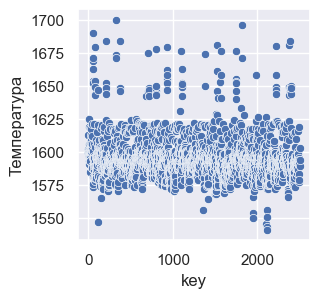

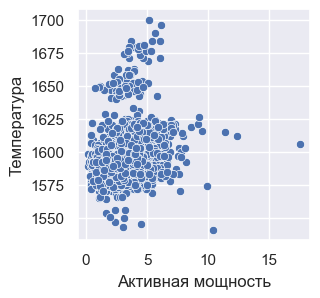

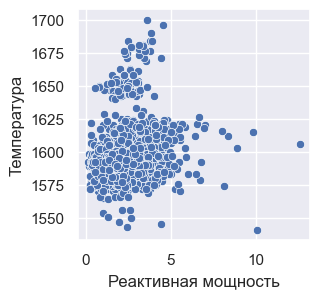

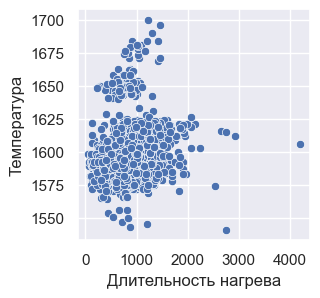

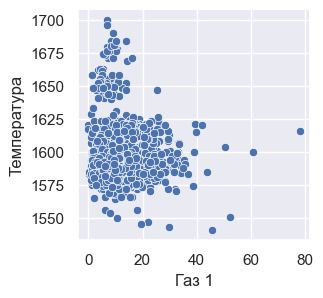

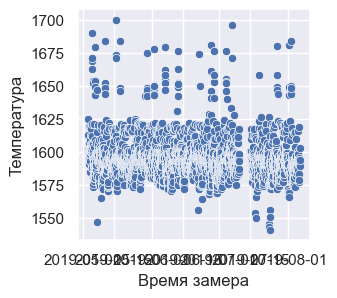

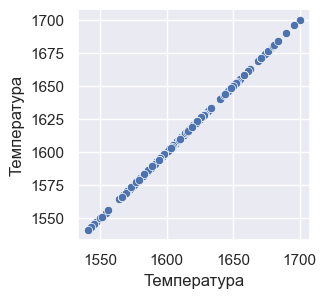

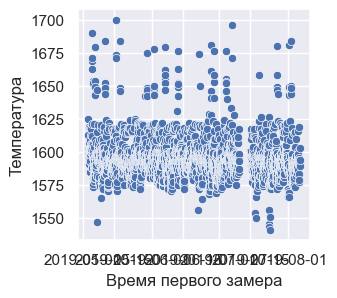

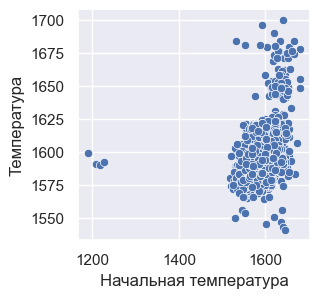

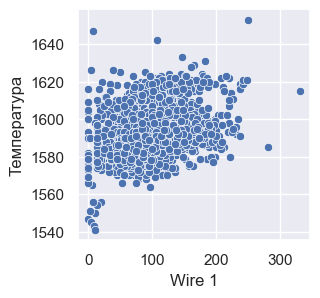

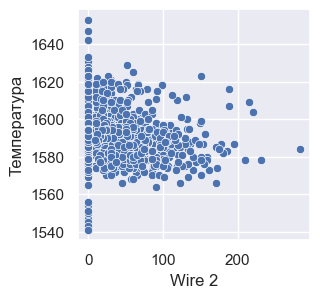

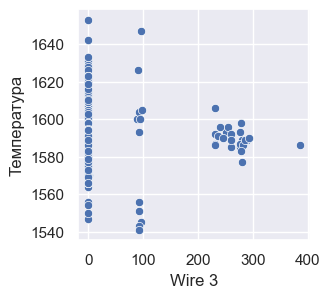

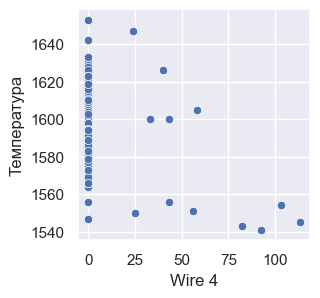

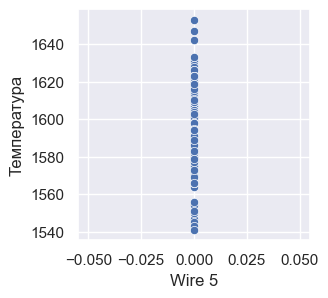

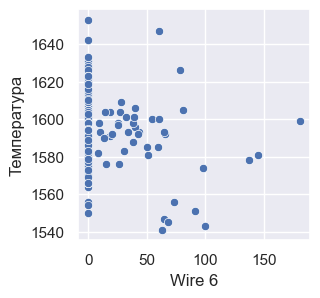

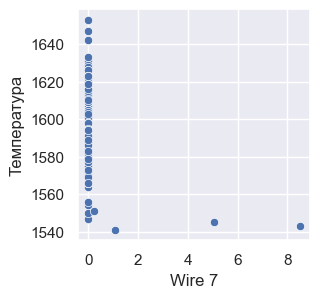

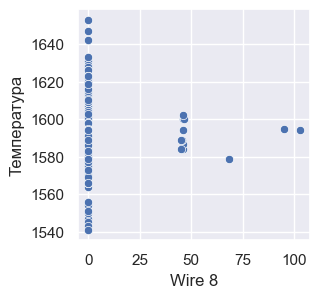

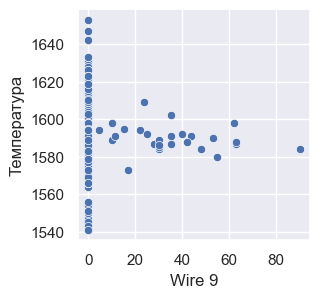

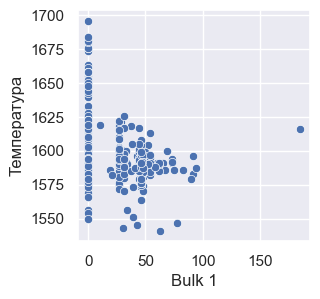

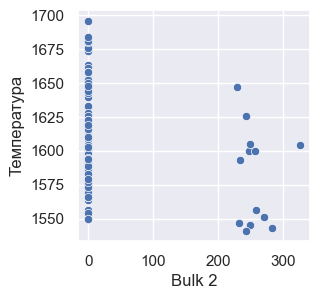

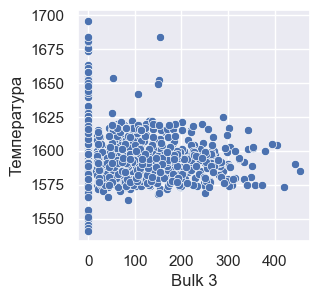

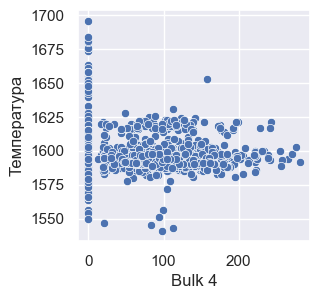

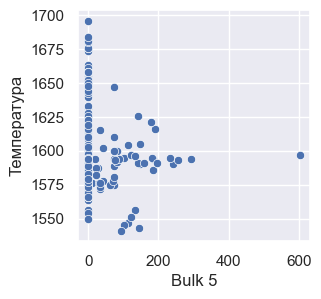

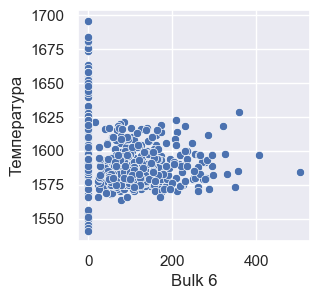

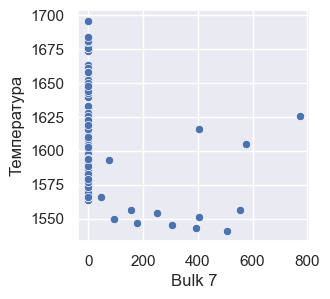

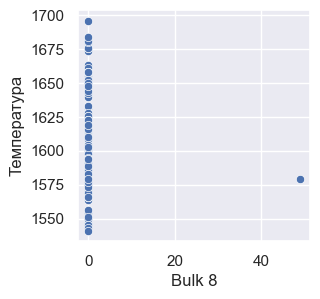

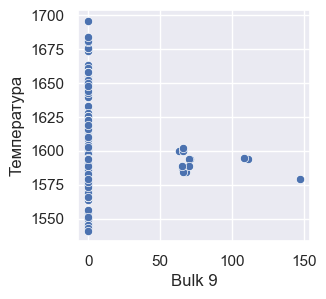

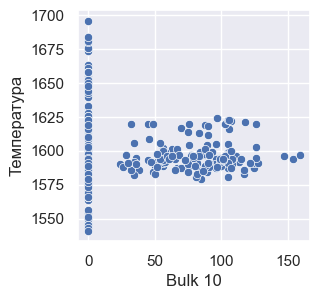

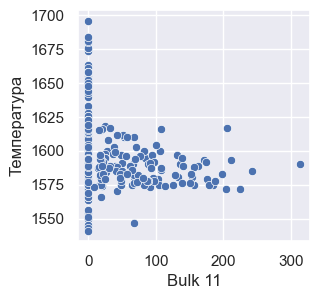

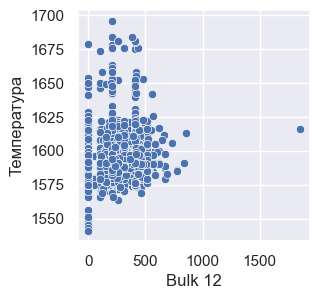

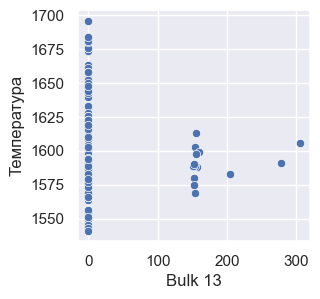

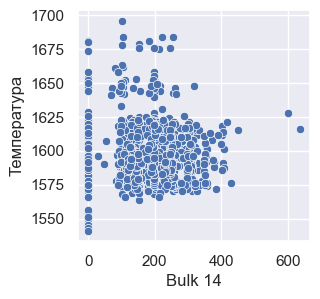

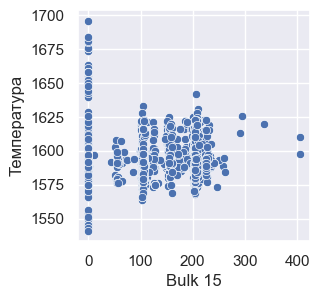

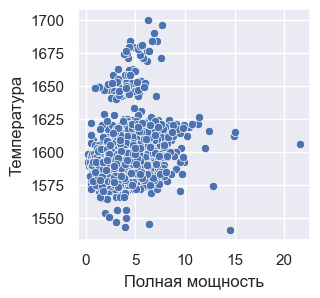

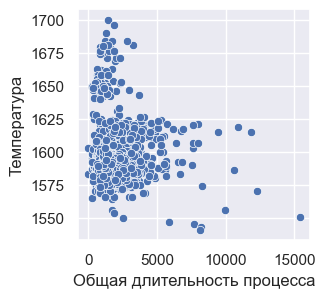

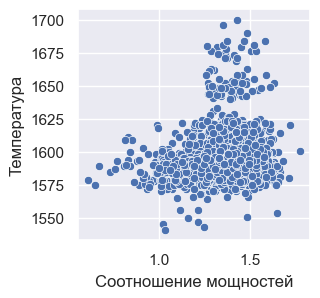

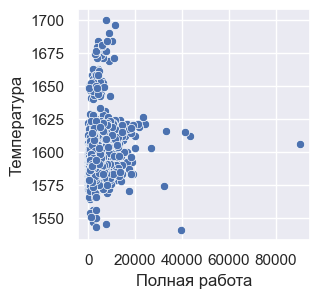

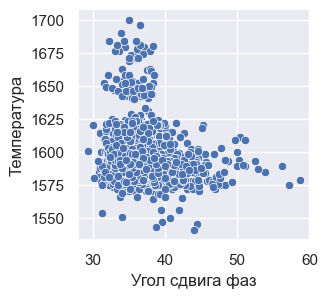

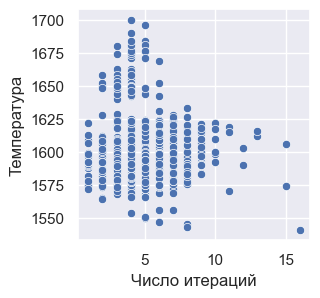

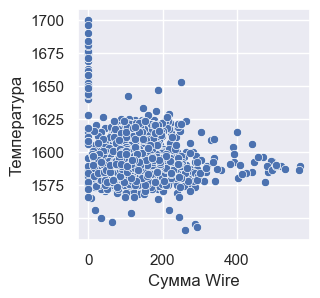

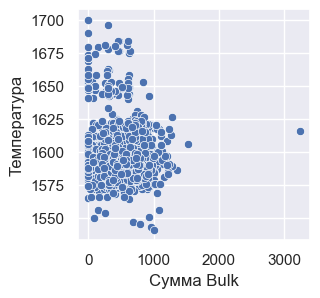

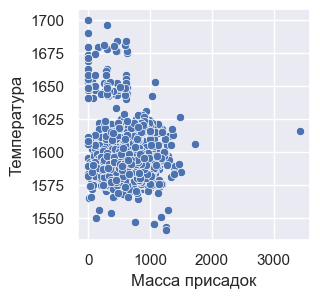

In [47]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(font_scale = 1)

for score in df.columns:
    plt.figure(figsize=(3,3))
    ax3 = sns.scatterplot(x = score, y =  'Температура', data = df)
    plt.show()

В той или иной степени все приведённые признаки коррелируют со значением целевого признака. Исключением являются 'Wire 5' и 'Bulk 8', мы и ранее уже отмечали эти признаки как в рамках решаемой задачи незначимые.

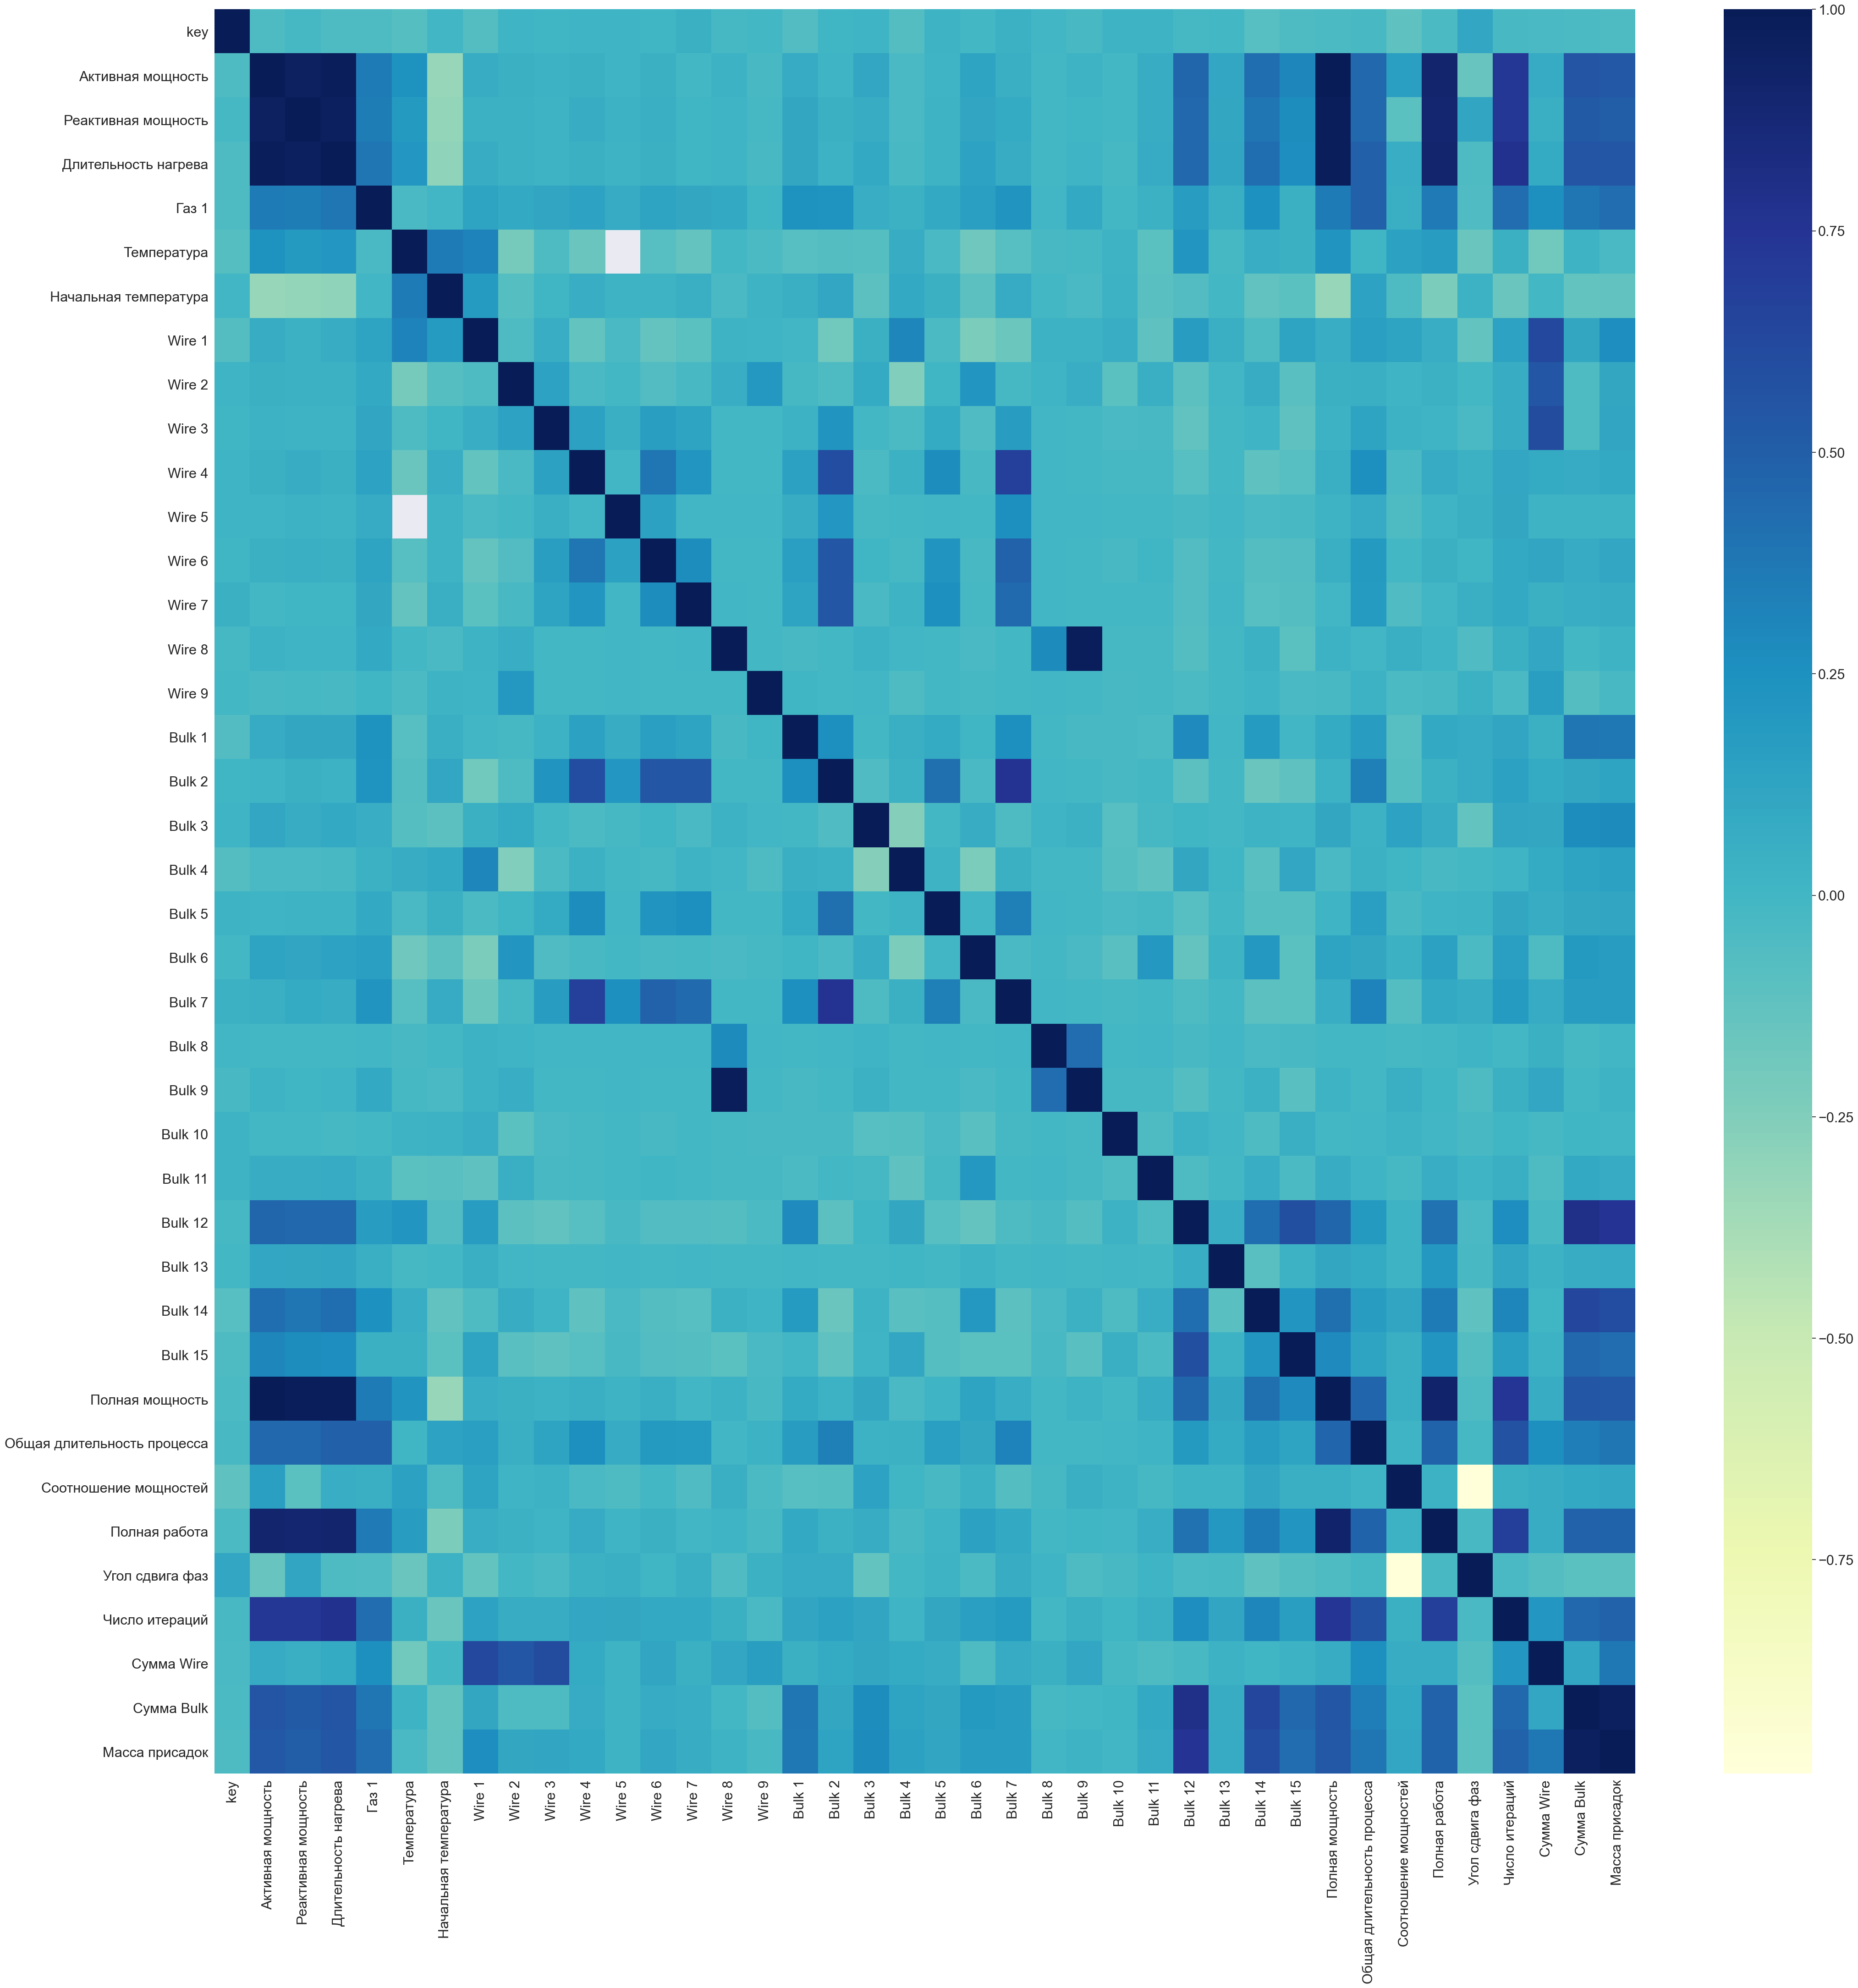

In [48]:
corr = df.corr()
plt.figure(figsize=(50,50))
sns.set(font_scale = 2)
sns.heatmap(corr, cmap="YlGnBu")
plt.show()

Линейные корреляции между признаками, конечно, наличествуют, в чем нет ничего неожиданного. Для моделей, основанных на "решающем дереве", эти корреляции влияют лишь на время обучения. Для линейных моделей наличие избыточных признаков критично скажется на метрике качества (что мы в дальнейшем и продемонстрируем).

In [49]:
#display(df.isna().sum())

df.drop(columns=['Время замера', 'Время первого замера'], inplace=True)

# Удаляем пропуски:

df.dropna(inplace=True)
df

,key,Активная мощность,Реактивная мощность,Длительность нагрева,Газ 1,Температура,Начальная температура,Wire 1,Wire 2,Wire 3,...,Bulk 15,Полная мощность,Общая длительность процесса,Соотношение мощностей,Полная работа,Угол сдвига фаз,Число итераций,Сумма Wire,Сумма Bulk,Масса присадок
key,,,,,,,,,,,,,,,,,,,,,
1,1.0,4.878147,3.183241,1098.0,29.749986,1613.0,1571.0,60.059998,0.00000,0.0,...,154.0,5.824889,861.0,1.532447,6395.728622,33.126511,5.0,60.059998,399.0,459.059998
2,2.0,3.052598,1.998112,811.0,12.555561,1602.0,1581.0,96.052315,0.00000,0.0,...,154.0,3.648398,1305.0,1.527741,2958.850582,33.207197,4.0,96.052315,428.0,524.052315
3,3.0,2.525882,1.599076,655.0,28.554793,1599.0,1596.0,91.160157,0.00000,0.0,...,153.0,2.989502,1300.0,1.579589,1958.124109,32.336928,5.0,91.160157,391.0,482.160157
4,4.0,3.209250,2.060298,741.0,18.841219,1625.0,1601.0,89.063515,0.00000,0.0,...,154.0,3.813674,388.0,1.557663,2825.932742,32.699946,4.0,89.063515,441.0,530.063515
5,5.0,3.347173,2.252643,869.0,5.413692,1602.0,1576.0,89.238236,9.11456,0.0,...,152.0,4.034596,762.0,1.485887,3506.063873,33.940500,4.0,98.352796,432.0,530.352796
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2495,2495.0,3.210690,2.360777,723.0,7.125735,1591.0,1570.0,89.150879,0.00000,0.0,...,223.0,3.985197,1137.0,1.360014,2881.297646,36.326537,4.0,89.150879,496.0,585.150879
2496,2496.0,4.203064,2.810185,940.0,9.412616,1591.0,1554.0,114.179527,0.00000,0.0,...,226.0,5.055976,1618.0,1.495654,4752.617092,33.766838,6.0,114.179527,570.0,684.179527
2497,2497.0,2.212379,1.851269,569.0,6.271699,1589.0,1571.0,94.086723,9.04800,0.0,...,226.0,2.884756,717.0,1.195061,1641.426283,39.921830,3.0,103.134723,439.0,542.134723


In [50]:
# Удаляем измерения, где температура была достигнута всего за одну итерацию (т.е. там нет начальных температур):
df = df[df['Число итераций'] != 1]

<a id='9'></a>
### 2.3 Разделение на тестовую и обучающую выборки. Очистка обучающей выборки от выбросов.

In [51]:
X = df.drop(columns='Температура')
y = df['Температура']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=2020)
X_train.shape

(1728, 39)

Поскольку единственным способом подбора гиперпараметров в нашей работе является RamdomizedSearchCV - метод, валидирующий метрику на данных обучающей выборки при помощи кроссвалидации, валидационная выборка нам не потребуется.

In [52]:
# Подчистим некоторые выбросы в обучающей выборке:

X_train = X_train[X_train['Начальная температура'] > 1300]
X_train = X_train[X_train['Общая длительность процесса'] < 4000]
X_train = X_train[X_train['Сумма Wire'] < 245]
X_train = X_train[X_train['Сумма Bulk'] < 1050]


In [53]:
X_train.shape

(1589, 39)

In [54]:
y_train = y_train[X_train.index]

## 3. Выбор модели

<a id='10'></a>
### 3.1 Линейная регрессия до отбора признаков

In [55]:
metrics = []
fitpred_time = []
# Сперва линейная регрессия:


model = LinearRegression()

lir_params = {'fit_intercept': [True, False],
                  'normalize': [True, False],
              
                  

                  }
    
lir_cv = GridSearchCV(model, lir_params, scoring='neg_mean_absolute_error')
lir_cv.fit(X_train, y_train)
lir_cv.best_params_

{'fit_intercept': True, 'normalize': True}

In [56]:
start = time.time()
model = LinearRegression(**lir_cv.best_params_)
model.fit(X_train, y_train)
lr1_pred = model.predict(X_test)
lr1_mae = mean_absolute_error(y_test, lr1_pred)


print('Линейная регрессия без отбора признаков: ', lr1_mae)
end = time.time()
metrics.append(lr1_mae)
fitpred_time.append(end-start)


Линейная регрессия без отбора признаков:  7.963753164636342


<a id='11'></a>
### 3.2 Lightgbm+Bagging до отбора признаков

In [57]:
%%time
# Осуществляем подбор гиперпараметров для lightgbm:
import lightgbm as lgb

#lightgbm.LGBMClassifier(boosting_type='gbdt', learning_rate = 0.005, num_leaves = 31, bagging_fraction = 0.7, feature_fraction = 0.6, min_data = 200, nrounds = 1968)

model = lgb.LGBMRegressor (n_jobs=-1)

params_lgb = { 'n_estimators':range(5, 300),
               'num_leaves': [8, 10,12,14],
               'max_depth': [2,4,6,8,10,12,14,16],
               'learning_rate': [0.1, 0.25, 0.5, 1],
               'min_data_in_leaf': [10, 20, 25, 30], 
               'random_state':[2020]
              }

lgmb_grid = RandomizedSearchCV(
     
    estimator=model,
    param_distributions=params_lgb,
    scoring='neg_mean_absolute_error',
    return_train_score=True,
    random_state=2020,    
    cv=4
)

lgmb_grid.fit(X_train, y_train)
print(lgmb_grid.best_params_)

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] min

In [58]:
%%time
# Lightgbm
start = time.time()

gbm = lgb.LGBMRegressor(**lgmb_grid.best_params_,
                        
                       # n_estimators=300,
                        
                       boosting_type='gbdt',
                       n_jobs=-1,
                         
                       #early_stopping_rounds=100,
                        # learning_rate=0.05,
                        # nrounds=10,
                        # num_iterations=1000
                       )



gbm.fit(X_train, y_train,
        eval_set=[(X_test, y_test)],
        eval_metric='mae',
     
      early_stopping_rounds=100,
        )

lgbm1_pred = gbm.predict(X_test)


lgbm1_mae = mean_absolute_error(y_test, lgbm1_pred)
print('Lightgbm до отбора признаков', lgbm1_mae)
end = time.time()
metrics.append(lgbm1_mae)
fitpred_time.append(end-start)





start = time.time()
model = BaggingRegressor(gbm, n_estimators=144, random_state=12345).fit(X_train, y_train)

lgbm1bag_pred = model.predict(X_test) 
lgbm1bag_mae = mean_absolute_error(y_test, lgbm1bag_pred)
print('Lightgbm + Bagging до отбора признаков', lgbm1bag_mae)
end = time.time()
metrics.append(lgbm1bag_mae)
fitpred_time.append(end-start)


[1]	valid_0's l1: 7.70599	valid_0's l2: 115.878
Training until validation scores don't improve for 100 rounds
[2]	valid_0's l1: 7.48694	valid_0's l2: 108.555
[3]	valid_0's l1: 7.32478	valid_0's l2: 103.704
[4]	valid_0's l1: 7.14569	valid_0's l2: 98.5024
[5]	valid_0's l1: 7.00361	valid_0's l2: 94.91
[6]	valid_0's l1: 6.89591	valid_0's l2: 91.444
[7]	valid_0's l1: 6.8034	valid_0's l2: 88.8006
[8]	valid_0's l1: 6.71731	valid_0's l2: 86.2395
[9]	valid_0's l1: 6.61147	valid_0's l2: 83.3543
[10]	valid_0's l1: 6.55027	valid_0's l2: 81.7789
[11]	valid_0's l1: 6.45931	valid_0's l2: 79.5986
[12]	valid_0's l1: 6.3728	valid_0's l2: 77.5421
[13]	valid_0's l1: 6.31051	valid_0's l2: 76.063
[14]	valid_0's l1: 6.22186	valid_0's l2: 74.2325
[15]	valid_0's l1: 6.15188	valid_0's l2: 72.7744
[16]	valid_0's l1: 6.09115	valid_0's l2: 71.5891
[17]	valid_0's l1: 6.02999	valid_0's l2: 70.0171
[18]	valid_0's l1: 5.97737	valid_0's l2: 68.8054
[19]	valid_0's l1: 5.94315	valid_0's l2: 68.2091
[20]	valid_0's l1: 5.9

<a id='12'></a>
### 3.3 Случайный лес

In [59]:
%%time
# 
    
# model = RandomForestRegressor(random_state=2020, n_jobs=-1, )

# rfr_params = { 'bootstrap': [True, False],
#               'max_depth': range(1,20),
#               'min_samples_split': range(2,18),
#               'min_samples_leaf': range(1,18),
#               'n_estimators': range(1,200),
#               'criterion':['mae']
#               }

# rfr_cv = RandomizedSearchCV(model, rfr_params, scoring='neg_mean_absolute_error', cv=5, random_state=2020,)
# rfr_cv.fit(X_train, y_train)
# rfr_cv.best_params_

Wall time: 0 ns


In [60]:
# rfr_cv.best_params_

In [61]:
%%time
start = time.time()
# {'bootstrap': True,  'criterion': 'mae',  'max_depth': 16,  'min_samples_leaf': 5,  'min_samples_split': 6,  'n_estimators': 157}

model = RandomForestRegressor(n_estimators=180, max_depth=12, min_samples_split=4, min_samples_leaf=1, n_jobs=-1, criterion='mae', random_state=2020) #- 6.88782

#model = RandomForestRegressor(**rfr_cv.best_params_, n_jobs=-1, random_state=2020)

model.fit(X_train, y_train)
rf_pred = model.predict(X_test)
rf_mae = mean_absolute_error(y_test, rf_pred)
print('Случайный лес: ', rf_mae)
end = time.time()
metrics.append(rf_mae)
fitpred_time.append(end-start)

Случайный лес:  5.708998842592595
Wall time: 18.1 s


<a id='13'></a>
### 3.4 Отбор признаков.  Lightgbm/+Bagging после отбора признаков.

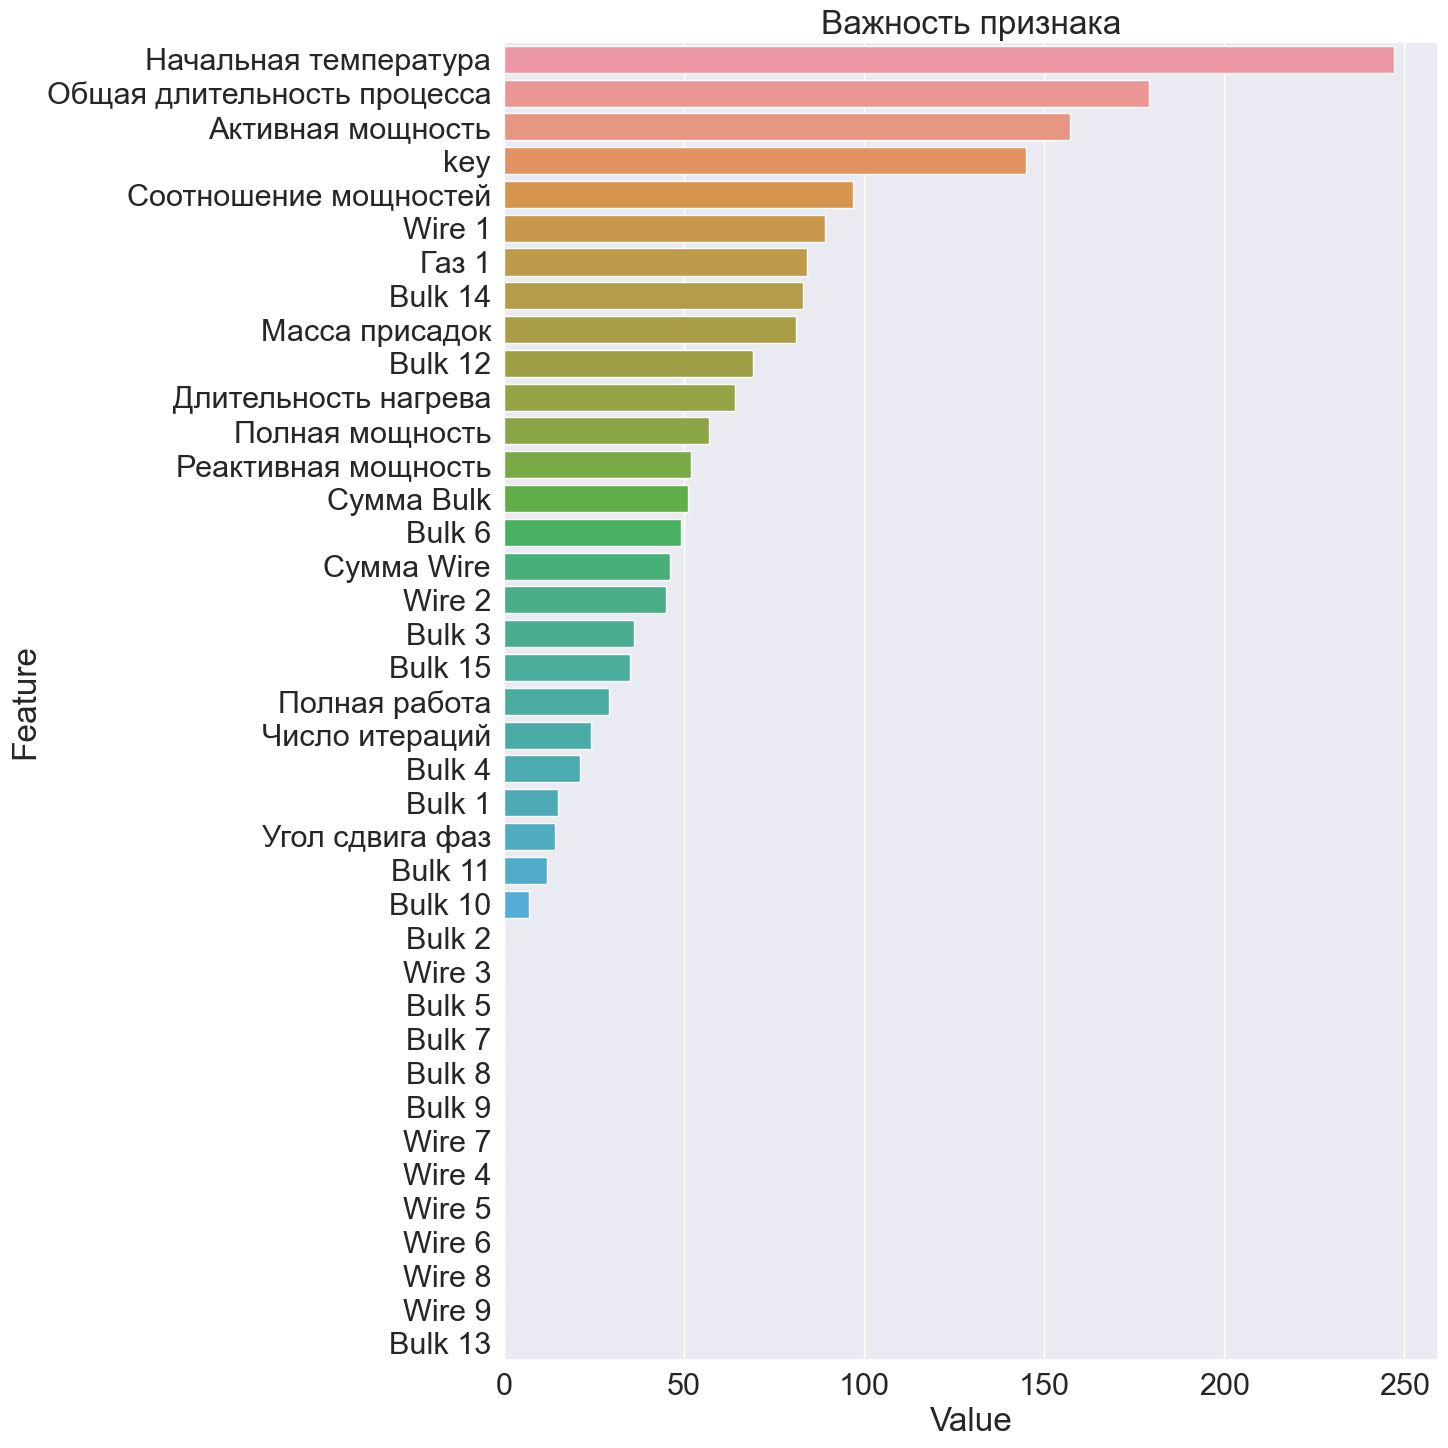

In [62]:
feature_imp = pd.DataFrame(sorted(zip(gbm.feature_importances_,X_train.columns)), columns=['Value','Feature'])
plt.figure(figsize=(15, 15))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('Важность признака')
plt.tight_layout()
plt.show()

In [63]:
feature_imp.query('Value == 0').Feature.values

array(['Bulk 13', 'Bulk 2', 'Bulk 5', 'Bulk 7', 'Bulk 8', 'Bulk 9',
       'Wire 3', 'Wire 4', 'Wire 5', 'Wire 6', 'Wire 7', 'Wire 8',
       'Wire 9'], dtype=object)

In [64]:
# Отбросим признаки, незначимые по критерию "feature importance":
X_train.drop(columns=feature_imp.query('Value == 0').Feature.values, inplace=True)
X_test.drop(columns=feature_imp.query('Value == 0').Feature.values, inplace=True)

In [65]:
%%time
# Осуществляем подбор гиперпараметров для lightgbm:

model = lgb.LGBMRegressor (n_jobs=-1)


params_lgb = { 'n_estimators':range(5, 200, 5),
               'num_leaves': [8, 10,12,14],
               'max_depth': [2,4,6,8,10,12,14,16],
               'learning_rate': [0.1, 0.25, 0.5, 1],
               'min_data_in_leaf': [10, 20, 25, 30], 
               'random_state':[2020]
              }

lgmb_grid = RandomizedSearchCV(
     
    estimator=model,
    param_distributions=params_lgb,
    scoring='neg_mean_absolute_error',
    return_train_score=True,
    random_state=2020,    
    cv=3
)

lgmb_grid.fit(X_train, y_train)
print(lgmb_grid.best_params_)

[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] min

In [66]:
%%time
# Lightgbm
start = time.time()
gbm = lgb.LGBMRegressor(**lgmb_grid.best_params_,
                        
                                            
                       boosting_type='gbdt',
                       n_jobs=-1,
                       # early_stopping_rounds=100,
                             eval_metric='mae',
                       )



gbm.fit(X_train, y_train,
        eval_set=[(X_test, y_test)],
        eval_metric='mae',
        early_stopping_rounds=100,
      
        )

lgbm2_pred = gbm.predict(X_test)


lgbm2_mae = mean_absolute_error(y_test, lgbm2_pred)
print('Lightgbm после отбора признаков: ', lgbm2_mae)
end = time.time()
metrics.append(lgbm2_mae)
fitpred_time.append(end-start)

[1]	valid_0's l1: 7.7217	valid_0's l2: 116.732
Training until validation scores don't improve for 100 rounds
[2]	valid_0's l1: 7.52502	valid_0's l2: 110.041
[3]	valid_0's l1: 7.38383	valid_0's l2: 105.521
[4]	valid_0's l1: 7.23238	valid_0's l2: 100.856
[5]	valid_0's l1: 7.10754	valid_0's l2: 97.2898
[6]	valid_0's l1: 6.99258	valid_0's l2: 94.3793
[7]	valid_0's l1: 6.89161	valid_0's l2: 91.4487
[8]	valid_0's l1: 6.82439	valid_0's l2: 89.5649
[9]	valid_0's l1: 6.72145	valid_0's l2: 86.7752
[10]	valid_0's l1: 6.6256	valid_0's l2: 84.5224
[11]	valid_0's l1: 6.53643	valid_0's l2: 82.0479
[12]	valid_0's l1: 6.48089	valid_0's l2: 80.4241
[13]	valid_0's l1: 6.41677	valid_0's l2: 78.8781
[14]	valid_0's l1: 6.34027	valid_0's l2: 76.9545
[15]	valid_0's l1: 6.29478	valid_0's l2: 76.0366
[16]	valid_0's l1: 6.23282	valid_0's l2: 74.645
[17]	valid_0's l1: 6.18087	valid_0's l2: 73.4268
[18]	valid_0's l1: 6.14658	valid_0's l2: 72.5176
[19]	valid_0's l1: 6.10289	valid_0's l2: 71.5414
[20]	valid_0's l1: 

In [67]:
%%time
# Осуществляем подбор гиперпараметров для lightgbm:
# from sklearn.ensemble import BaggingRegressor

# model = BaggingRegressor(gbm, random_state=2020).fit(X_train, y_train)



# params_br = { 'n_estimators':range(5, 200, 20),
              
#               }

# br_rand = RandomizedSearchCV(
     
#     estimator=model,
#     param_distributions=params_br,
#     scoring='neg_mean_absolute_error',
#     return_train_score=True,
#     random_state=2020,    
   
# )

# br_rand.fit(X_train, y_train)
# print(br_rand.best_params_)

Wall time: 0 ns


In [68]:
start = time.time()
model = BaggingRegressor(gbm, n_estimators=45, random_state=2020).fit(X_train, y_train)

lgbm2bag_pred = model.predict(X_test) 

lgbm2bag_mae = mean_absolute_error(y_test, lgbm2bag_pred)
print('Lightgbm + Bagging после отбора признаков', lgbm2bag_mae)
end = time.time()
metrics.append(lgbm2bag_mae)
fitpred_time.append(end-start)

[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25
Lightgbm + Bagging после отбора признаков 5.278195830394694


<a id='14'></a>
### 3.5 Линейная регрессия после отбора признаков

In [69]:
%%time
from sklearn.linear_model import LinearRegression
    
model = LinearRegression()

lir_params = {'fit_intercept': [True, False],
                  'normalize': [True, False],
              
                  

                  }
    
lir_cv = GridSearchCV(model, lir_params, scoring='neg_mean_absolute_error')
lir_cv.fit(X_train, y_train)
lir_cv.best_params_

Wall time: 228 ms


{'fit_intercept': True, 'normalize': False}

In [70]:
start = time.time()
model = LinearRegression(**lir_cv.best_params_)

model.fit(X_train, y_train)
lr2_pred = model.predict(X_test)
lr2_mae = mean_absolute_error(y_test, lr2_pred)
print(lr2_mae)
end = time.time()
metrics.append(lr2_mae)
fitpred_time.append(end-start)

6.030423457253345


<a id='15'></a>
### 3.6 Константная модель

In [71]:
start = time.time()
y_constant= pd.Series([y_train.mean()]*len(y_test))
const_mae = mean_absolute_error(y_test, y_constant)
print('MAE константной модели: {}'.format(const_mae))
end = time.time()
metrics.append(const_mae)
fitpred_time.append(end-start)

MAE константной модели: 7.934196035242284


<a id='16'></a>
## 5. Сравнение моделей

In [72]:
# Сведем данные по работе моделей в один датафрейм:


comparison_data = pd.DataFrame({'МАЕ': metrics, 'Время обучения и предсказания, сек': fitpred_time}, index=['LinearRegression до отбора', 'Lightgbm до отбора', 'Lightgbm+Bag до отбора', 'Случайный лес', 'Lightgbm после отбора', 'Lightgbm+Bag после отбора', 'LinearRegression после отбора', 'Константная модель'])
display(comparison_data)

,МАЕ,"Время обучения и предсказания, сек"
LinearRegression до отбора,7.963753,0.018989
Lightgbm до отбора,5.324639,0.363776
Lightgbm+Bag до отбора,5.225282,24.557892
Случайный лес,5.708999,18.127581
Lightgbm после отбора,5.284131,0.235856
Lightgbm+Bag после отбора,5.278196,5.646175
LinearRegression после отбора,6.030423,0.009988
Константная модель,7.934196,0.001997


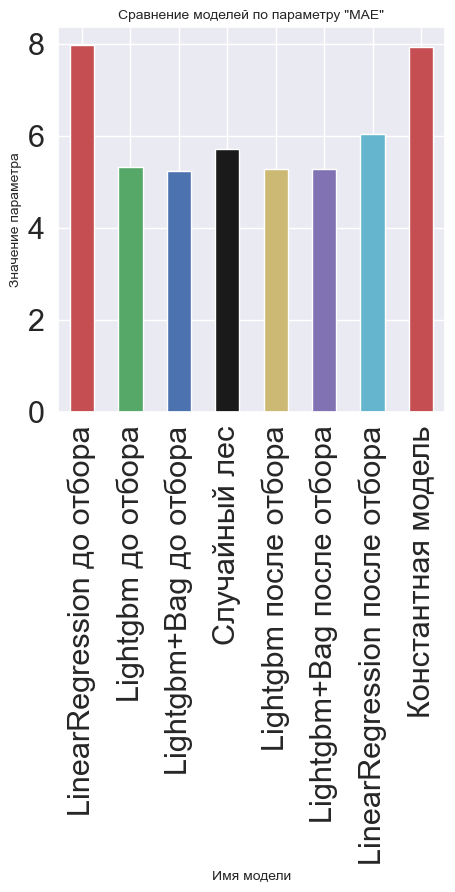

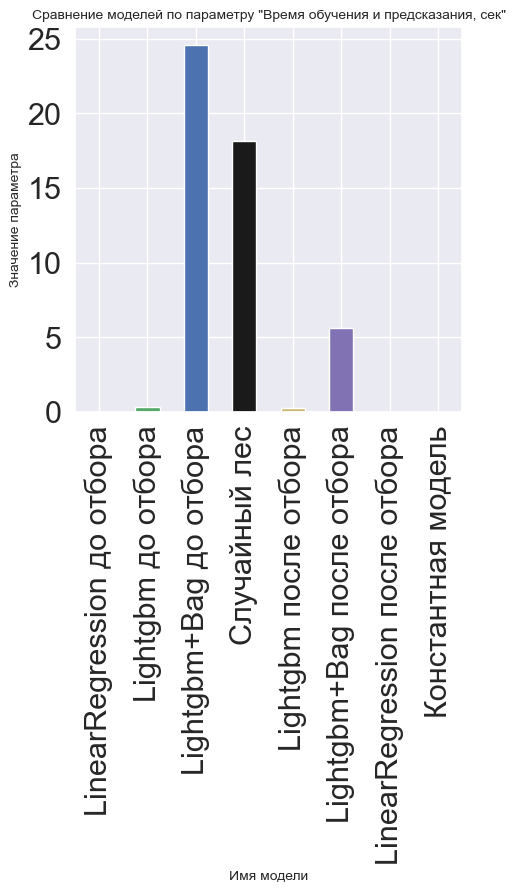

In [81]:
# Представим полученные данные в графическом виде:
for column in comparison_data.columns:
    
    comparison_data[column].plot(kind = 'bar', grid = True , figsize = (5,5), color =  list('rgbkymc'))
    plt.xlabel('Имя модели', fontsize=10)
    plt.ylabel('Значение параметра', fontsize=10)
    plt.title('Сравнение моделей по параметру "{}"'.format(column), fontsize=10)
    plt.show()

<a id='17'></a>
## 6. Выводы

1) Нами была проделана необходимая для применения моделей машинного обучения подготовка данных. Лишние таблицы были отброшены, слишком большие - сведены вместе с сохранением значащей информации. Получившийся датафрейм был разделен на тестовую и обучающую выборки, из обучающей были удалены выбросы.

2) Мы применили несколько моделей машинного обучения и сравнили получившиеся результаты.

3) Помимо этого была проведен отбор признаков и было отмечено его влияние на те или иные модели. Наилучшая метрика MAE 5.22 - у Lightgbm+Bagging до отбора признаков. Отбрасывание лишних признаков значительно (с 7.96 до 6.03) улучшило метрику модели LinearRegression. Метрики для остальных моделей остались без изменений (незначительные колебания обусловлены подбором гиперпараметров при помоищ RamdomizedSearchCV)

4) Получившаяся наилучшая метрика MAE с запасом удовлетворяет требованиям, указанным в техническом задании (MAE < 6), а все модели машинного обучения - превосходят константную модель и, таким образом, проходят 'sanity check'.